# DATA 620 - Assignment (Weeks 10/11)

Derek G Nokes


In [3]:
import nltk
import random
import pandas
import numpy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import collections
import itertools
#from nltk.corpus import stopwords, reuters
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist

from nltk import metrics
from nltk.classify.util import accuracy

from nltk.classify import NaiveBayesClassifier
from nltk.classify import DecisionTreeClassifier
from nltk.classify import MaxentClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from nltk.classify import util, ClassifierI, MultiClassifierI

# graphics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn

# set display digits
display_digits=4

# download NLTK support files
#nltk.download()

# inline matplotlib
%matplotlib inline

## Introduction

In this assignment, we gather a set of company descriptions and sector/industry/sub-industry classifications via web-scraping. Our corpus is a set of 9000+ company descriptions scrapped from the public Bloomberg website. We then develop and test a set of classifiers to assign Bloomberg Industry Classification System (BICS) sector labels to each company based on the company descriptions.

## Data Acquisition

In this section, we acquire company descriptions and sector classifications for all available tickers in the Russell 1000, S&P 1500, and Russell 2000 over the period 1995 to 2017. For a small subset of these companies, descriptions and sectors were not available on the public website of Bloomberg and thus could not be acquired via web-scraping.

The following two code sections cannot be run without a database that contains the tickers associated with the index constituents of the Russell 1000, Russell 2000, and S&P1500. The code below can easily be adapted to web-scrape the company descriptions and BICS classifications for any set of Bloomberg tickers.

In [4]:
import pandas
import numpy
import requests
import datetime
import MySQLdb
import mysqlDatabaseToolbox
from bs4 import BeautifulSoup
import pandas.io.sql as sql

# https://www.bloomberg.com/quote/IBM:US
# https://www.bloomberg.com/quote/0062761Q:US

def fetchCompanyDescription(tickerBB,compositeExchangeCodeBB):
    # build URL
    url='https://www.bloomberg.com/quote/'+tickerBB+':'+compositeExchangeCodeBB
    # start a session
    s = requests.session()
    # set parameters
    parameters = {'siteEntryPassthrough': True}
    # get page
    response = s.get(url, params=parameters)
    # extract page
    soup = BeautifulSoup(response.text,"lxml")
    # extract h1 content
    h1=soup.findAll("h1")
    # extract instrument name
    instrumentNameBB=str(h1[2].text).strip()
    #
    # create dictionary to hold instrument classifications
    classificationsDictionary=dict()
    # add instrument name
    classificationsDictionary['instrumentNameBB']=instrumentNameBB
    # extract body    
    divs=soup.findAll('div')
    # iterate over each section in 'body'
    for div in divs:
        if 'profile__description' in str(div):
            #print(div)
            chunk=div
        
    companyDescription=str(chunk.text).strip()
            
    classificationsDictionary['companyDescription']=companyDescription

    return classificationsDictionary

def fetchInstrumentCharacteristics(tickerBB,compositeExchangeCodeBB):
    # build URL
    url='https://www.bloomberg.com/quote/'+tickerBB+':'+compositeExchangeCodeBB
    # start a session
    s = requests.session()
    # set parameters
    parameters = {'siteEntryPassthrough': True}
    # get page
    response = s.get(url, params=parameters)
    # extract page
    soup = BeautifulSoup(response.text,"lxml")
    # extract h1 content
    h1=soup.findAll("h1")
    # extract instrument name
    instrumentNameBB=str(h1[2].text).strip()
    #
    # create dictionary to hold instrument classifications
    classificationsDictionary=dict()
    # add instrument name
    classificationsDictionary['instrumentNameBB']=instrumentNameBB
    # extract body    
    body=soup.findAll('body')
    # iterate over each section in 'body'
    for line in body:
        # find line with 'bic'
        if 'bic' in str(line):
            # split on comma
            lines=str(line).split(',')
            # iterate over each chunk
            for chunk in lines:
                # if 'bic' in chunk
                if 'bic' in str(chunk):
                    # split field and value
                    classifications=chunk.split(':')
                    # remove quotes from field name
                    field=classifications[0].replace('"','')
                    # remove quotes from value
                    value=classifications[1].replace('"','')
                    # add field and value to classification dictionary
                    classificationsDictionary[str(field)]=str(value)
              
    # extract body    
    divs=soup.findAll('div')
    # iterate over each section in 'body'
    for div in divs:
        if 'profile__description' in str(div):
            #print(div)
            chunk=div
        
    companyDescription=str(chunk.text).strip()
            
    classificationsDictionary['companyDescription']=companyDescription                

    return classificationsDictionary

def iterateFetchInstrumentCharacteristics(outputDirectory,errorDirectory,tickerListBB):
    # find current datetime (timestamp)
    dateTime=datetime.datetime.now()
    # create instrument output file name
    outputFileName='instrumentMaster-'+dateTime.strftime('%Y%m%d_%H%M%S')
    # create error output file name
    errorFileName='instrumentMasterError-'+dateTime.strftime('%Y%m%d_%H%M%S')
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # open error file handle
    errorFileHandle=open(errorDirectory+errorFileName,'w')    
    
    # create dictionary to hold errors
    errorDictionary=dict()    
    # create dictionary to hold instrument characteristics
    instrumentDictionary=dict()
    # iterate over each instrument
    for instrumentTicker in tickerListBB:
        # extract ticker and composite exchange code
        tickerBB,compositeExchangeCodeBB=instrumentTicker.split()
        
        try:
            # fetch instrument characteristics
            classificationsDictionary=fetchInstrumentCharacteristics(tickerBB,compositeExchangeCodeBB)
            # extract instrument name
            instrumentNameBB=classificationsDictionary['instrumentNameBB']
            #
            companyDescription=classificationsDictionary['companyDescription']
            # extract sector
            bicsSector=classificationsDictionary['bicsSector']
            # extract industry
            bicsIndustry=classificationsDictionary['bicsIndustry']
            # extract sub-industry
            bicsSubIndustry=classificationsDictionary['bicsSubIndustry']
            # write to output file
            outputFileHandle.write(str(tickerBB)+"|"+str(compositeExchangeCodeBB)+"|"+str(companyDescription)+"|"+str(instrumentNameBB)+"|"+str(bicsSector)+"|"+str(bicsIndustry)+"|"+str(bicsSubIndustry)+"\n")
            # add dictionary 
            instrumentDictionary[tickerBB]=classificationsDictionary
        except:    
            print('==>Could not fetch:'+ str(instrumentTicker))
            #
            errorFileHandle.write(str(tickerBB)+"|"+str(compositeExchangeCodeBB)+"\n")
            # add to dictionary
            errorDictionary['tickerBB']=tickerBB
            
    
    # close output file handle
    outputFileHandle.close()
    # close error file handle
    errorFileHandle.close()
    
    return instrumentDictionary,errorDictionary

# load data to database

# CONNECT TO DB
# data server database parameters
dbHost='localhost'
dbPort=3306
dbUser='root'
dbPassword='password'
databaseName='global_monitoring'

## connect to the 'global_monitoring' MySQL database 
dbHandle=mysqlDatabaseToolbox.dbConnect(dbHost,dbPort,dbUser,dbPassword,databaseName)

outputDirectory="D:/marketData/global_monitoring/instrument_universe/index_member/Russell_3000/instrument_master/"

errorDirectory="D:/marketData/global_monitoring/instrument_universe/index_member/Russell_3000/instrument_master/"

query="SELECT DISTINCT index_member_ticker_bb FROM global_monitoring.bb_index_members ORDER BY index_member_ticker_bb;"

instrumentDf=sql.read_sql(query,dbHandle)

f=lambda x : x.replace(' UN',' US').replace(' UQ',' US').replace(' UW',' US').replace(' UA',' US').replace(' UU',' US').replace(' UR',' US').replace(' UP',' US').replace(' UV',' US')

instrumentDf['tickerBB']=instrumentDf['index_member_ticker_bb'].apply(f)
instrumentDf.drop_duplicates(subset=['tickerBB'],inplace=True)
tickerListBB=instrumentDf['tickerBB'].values.tolist()
instrumentDictionary,errorDictionary=iterateFetchInstrumentCharacteristics(outputDirectory,errorDirectory,tickerListBB)

# disconnect from MySQL
mysqlDatabaseToolbox.dbDisconnect(dbHandle)

In [ ]:
# create file load file
import json
import requests
import sys
import datetime
import pandas
import mysqlDatabaseToolbox
import MySQLdb

#==============================================================================
# 
#==============================================================================
# Example Call:
#
# Call:
# 
#
#------------------------------------------------------------------------------
def dbCreateInstrumentMasterTable(dbHandle,table):

    try:
        cursor = dbHandle.cursor()
        cursor.execute('CREATE TABLE '+str(table)+' (dbUpdateTimestamp TIMESTAMP, tickerBB VARCHAR(20) NOT NULL,compositeExchangeCodeBB VARCHAR(4) NOT NULL, companyDescription TEXT NOT NULL, instrumentNameBB VARCHAR(100) NOT NULL, bicsSector VARCHAR(40) NULL, bicsIndustry VARCHAR(60) NULL, bicsSubIndustry VARCHAR(60) NULL, PRIMARY KEY ( tickerBB,compositeExchangeCodeBB ) ) ENGINE=INNODB')
                   
    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])

    return

#==============================================================================
# 
#==============================================================================
# Example Call:
#
# Call:
# 
#
#------------------------------------------------------------------------------
def dbBulkLoadInstrumentMasterTable(dbHandle,table,directoryName,fileName):
# 
    try:
        cursor = dbHandle.cursor()
        sql="LOAD DATA LOCAL INFILE '" + directoryName + fileName + "' REPLACE INTO TABLE "+str(table)+" FIELDS TERMINATED BY '|' LINES TERMINATED BY '\r\n' IGNORE 1 LINES (tickerBB, compositeExchangeCodeBB, companyDescription, instrumentNameBB, bicsSector, bicsIndustry, bicsSubIndustry);"
        #print(sql)
        cursor.execute(sql)
        dbHandle.commit()
    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])
        dbHandle.rollback()

    return

#==============================================================================
# 
#==============================================================================
# Example Call:
#
# Call:
# 
#
#------------------------------------------------------------------------------
def dbCreateInstrumentMasterFIGITable(dbHandle,table):

    try:
        cursor = dbHandle.cursor()
        cursor.execute('CREATE TABLE '+str(table)+' (dbUpdateTimestamp TIMESTAMP, tickerBB VARCHAR(20) NOT NULL, compositeExchangeCodeBB VARCHAR(4) NOT NULL, companyDescription TEXT NOT NULL, instrumentNameBB VARCHAR(100) NOT NULL, bicsSector VARCHAR(40) NULL, bicsIndustry VARCHAR(60) NULL, bicsSubIndustry VARCHAR(60) NULL,	bbName VARCHAR(100) NOT NULL, bbTicker VARCHAR(20) NOT NULL, bbExchCode VARCHAR(4) NULL, bbCompositeFIGI VARCHAR(24) NOT NULL, bbFIGI VARCHAR(24) NOT NULL, bbMarketSector VARCHAR(12) NULL, bbSecurityDescription VARCHAR(16) NULL, bbSecurityType VARCHAR(24) NULL, bbSecurityType2 VARCHAR(40) NULL,	bbShareClassFIGI VARCHAR(24) NULL, bbUniqueID VARCHAR(40) NULL, PRIMARY KEY ( tickerBB,compositeExchangeCodeBB,bbCompositeFIGI ) ) ENGINE=INNODB')
                   
    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])

    return

#==============================================================================
# 
#==============================================================================
# Example Call:
#
# Call:
# 
#
#------------------------------------------------------------------------------
def dbBulkLoadInstrumentMasterFIGITable(dbHandle,table,directoryName,fileName):
# 
    try:
        cursor = dbHandle.cursor()
        sql="LOAD DATA LOCAL INFILE '" + directoryName + fileName + "' REPLACE INTO TABLE "+str(table)+" FIELDS TERMINATED BY '|' LINES TERMINATED BY '\r\n' IGNORE 1 LINES (tickerBB, compositeExchangeCodeBB, companyDescription, instrumentNameBB, bicsSector, bicsIndustry, bicsSubIndustry, bbName, bbTicker, bbExchCode, bbCompositeFIGI, bbFIGI, bbMarketSector, bbSecurityDescription, bbSecurityType, bbSecurityType2, bbShareClassFIGI, bbUniqueID);"
        #print(sql)
        cursor.execute(sql)
        dbHandle.commit()
    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])
        dbHandle.rollback()

    return


openfigi_url = 'https://api.openfigi.com/v1/mapping'
openfigi_apikey = 'db87e748-3ac5-44e4-af7a-c285d54254dc'  # Put API Key here
openfigi_headers = {'Content-Type': 'text/json'}

if openfigi_apikey:
    openfigi_headers['X-OPENFIGI-APIKEY'] = openfigi_apikey

def map_jobs(jobs):
    '''
    Send an collection of mapping jobs to the API in order to obtain the
    associated FIGI(s).

    Parameters
    ----------
    jobs : list(dict)
        A list of dicts that conform to the OpenFIGI API request structure. See
        https://www.openfigi.com/api#request-format for more information. Note
        rate-limiting requirements when considering length of `jobs`.

    Returns
    -------
    list(dict)
        One dict per item in `jobs` list that conform to the OpenFIGI API
        response structure.  See https://www.openfigi.com/api#response-fomats
        for more information.
    '''
    too_many_mapping_jobs = len(jobs) > (100 if openfigi_apikey else 10)
    assert not too_many_mapping_jobs, 'Too many mapping jobs'
    response = requests.post(url=openfigi_url, headers=openfigi_headers,
                             data=json.dumps(jobs))
    if response.status_code != 200:
        print(response.status_code)
        sys.exit(1)
    return response.json()


def pretty_dict(d):
    '''
    Format a dict for `print`ing.

    Parameters
    ----------
    d : dict
        The dict to format

    Returns
    -------
    string
        A "pretty" string represention of `d`.
    '''
    return '|'.join(['%s=%s' % (k, v) for k, v in d.iteritems() if v])


def job_results_handler(jobs, job_results,master,outputFileHandle):
    '''
    Handle the `map_jobs` results.  See `map_jobs` definition for more info.

    Parameters
    ----------
    jobs : list(dict)
        The original list of mapping jobs to perform.
    job_results : list(dict)
        The results of the mapping job.

    Returns
    -------
        None
    '''
        
    for job, result in zip(jobs, job_results):

        instrumentTicker=job['idValue']

        try:
            nResults=len(result['data'])
            #print(nResults)
            
            for i in range(0,nResults):

                instrumentDictionary=result['data'][i]
                #
                bbName=instrumentDictionary['name']
                bbTicker=instrumentDictionary['ticker']
                bbExchCode=instrumentDictionary['exchCode']
                bbCompositeFIGI=instrumentDictionary['compositeFIGI']
                bbFIGI=instrumentDictionary['figi']
                bbMarketSector=instrumentDictionary['marketSector']
                bbSecurityDescription=instrumentDictionary['securityDescription']
                bbSecurityType=instrumentDictionary['securityType']
                bbSecurityType2=instrumentDictionary['securityType2']
                bbShareClassFIGI=instrumentDictionary['shareClassFIGI']
                bbUniqueID=instrumentDictionary['uniqueID']
                
                outputList=[master[instrumentTicker],bbName,bbTicker,bbExchCode,bbCompositeFIGI,
                    bbFIGI,bbMarketSector,bbSecurityDescription,bbSecurityType,bbSecurityType2,
                    bbShareClassFIGI,bbUniqueID]
                output='|'.join(outputList)+'\n'
                #output=master[instrumentTicker]+'|'+bbName+'|'+bbTicker+'|'+bbExchCode+'|'+bbCompositeFIGI+'|'+bbFIGI+'|'+bbMarketSector+'|'+bbSecurityDescription+'|'+bbSecurityType+'|'+bbSecurityType2+'|'+bbShareClassFIGI+'|'+bbUniqueID+'\n'        
                outputFileHandle.write(output)
        except:
            pass

    return

def mapIndexMember2OpenFIGI(dbHandle,table,outputDirectory):
    # determine effective datetime
    effectiveDateTime=datetime.datetime.now()
    # define output file name
    outputFileName='instrument_master_figi-'+effectiveDateTime.strftime('%Y%m%d_%H%M%S')
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # define header
    header="tickerBB|compositeExchangeCodeBB|companyDescription|instrumentNameBB|bicsSector|bicsIndustry|bicsSubIndustry|bbName|bbTicker|bbExchCode|bbCompositeFIGI|bbFIGI|bbMarketSector|bbSecurityDescription|bbSecurityType|bbSecurityType2|bbShareClassFIGI|bbUniqueID\n"
    # write header
    outputFileHandle.write(header)
    # get database cursor
    cursor = dbHandle.cursor()
    # define SQL query
    query="SELECT tickerBB,compositeExchangeCodeBB,companyDescription,instrumentNameBB,bicsSector,bicsIndustry,bicsSubIndustry FROM "+str(table)+";"
    # define row limit (set by Bloomberg)
    rowLimit=100
    # exectute query, return number of rows
    nRows = cursor.execute(query)
    # while there are records
    while True:
        # fetch rowLimit number of records
        limitedRows = cursor.fetchmany(rowLimit)
        # find number of rows
        n=len(limitedRows)
        # if empty
        if limitedRows == ():
            # stop
            break
        # if not empty
        else:
            # define dictionary for storing jobs
            jobs=list()
            # define dictionary for storing master data
            master=dict()
            # iterate over each record
            for i in range(0,n):
                # extract the record into line
                line=limitedRows[i]
                # convert to pipe-delimited string
                lineString='|'.join(line)
                # print the line string
                print(lineString)
                # store job for line
                jobs.append({'idType': 'TICKER', 'idValue': str(line[0]),'exchCode': 'US'})
                # line string
                master[line[0]]=lineString
                                    
            # map jobs into results
            job_results = map_jobs(jobs)
            # handle the job results
            job_results_handler(jobs, job_results, master,outputFileHandle)
        
    # close output file handle
    outputFileHandle.close()
    
    # return output file name
    return outputFileName,nRows


# CONNECT TO DB
# data server database parameters
dbHost='localhost'
dbPort=3306
dbUser='root'
dbPassword='password'
databaseName='global_monitoring'

## connect to the 'global_monitoring' MySQL database 
dbHandle=mysqlDatabaseToolbox.dbConnect(dbHost,dbPort,dbUser,dbPassword,
    databaseName)

# define input directory
inputDirectory='D:/marketData/global_monitoring/instrument_universe/index_member/instrument_master/raw/'
# define output directory
outputDirectory='D:/marketData/global_monitoring/instrument_universe/index_member/instrument_master/preprocess/'
# define input file name
inputFileName='instrumentMaster-20171107_232325'
# define instrument master table name
instrument_master_table='bb_instrument_master'
# define FIGI instrument master table name
instrument_figi_master_table='bb_figi_instrument_master'
# define output file name
outputFileName=instrument_master_table

# define output column names
columnNames=['tickerBB','compositeExchangeCodeBB','companyDescription',
    'instrumentNameBB','bicsSector','bicsIndustry','bicsSubIndustry']
# read instrument master
instrumentMaster=pandas.read_csv(inputDirectory+inputFileName,sep='|',
    header=None,names=columnNames,keep_default_na=False)
# write instrument master with header
instrumentMaster.to_csv(outputDirectory+outputFileName,sep='|',index=False)
# create the database table
if not mysqlDatabaseToolbox.doesTableExist(dbHandle,instrument_master_table):
    # create table
    dbCreateInstrumentMasterTable(dbHandle,instrument_master_table)

# create the database table
if not mysqlDatabaseToolbox.doesTableExist(dbHandle,instrument_figi_master_table):
    # create table
    dbCreateInstrumentMasterFIGITable(dbHandle,instrument_figi_master_table)

# bulk load table
dbBulkLoadInstrumentMasterTable(dbHandle,instrument_master_table,
    outputDirectory,outputFileName)

# map instrument master to FIGI
outputFMapileName,nRows=mapIndexMember2OpenFIGI(dbHandle,instrument_master_table,
    outputDirectory)

# bulk load table
dbBulkLoadInstrumentMasterFIGITable(dbHandle,instrument_figi_master_table,
    outputDirectory,outputFMapileName)

# disconnect from MySQL
mysqlDatabaseToolbox.dbDisconnect(dbHandle)

In this section, we load a flat file containing the scraped data:

In [5]:
# define output directory
inputDirectory='D:/marketData/global_monitoring/instrument_universe/index_member/instrument_master/preprocess/'
#inputDirectory='C:/Users/derek/OneDrive/Documents/GitHub/DATA_620/Assignments/W10_W11/'
#inputDirectory='C:/Users/nok30/Documents/'
# define output file name
#inputFileName='bb_instrument_master.txt'
inputFileName='bb_instrument_master'
# load instrument details
instrumentMaster=pandas.read_csv(inputDirectory+inputFileName,sep='|',
    keep_default_na=False)
# extract sub-set of data required for BICS sector classification
df=instrumentMaster[['companyDescription','bicsSector']]
# display first 10
df.head(10)

,companyDescription,bicsSector
0,"MotivePower Industries, Inc. merged with and i...",Industrials
1,Spirit Finance Corporation is a real estate in...,Financials
2,"Chase Industries, Inc. manufactures and market...",Consumer Discretionary
3,"Sizeler Property Investors, Inc. operates as a...",Financials
4,"SEMCO Energy, Inc. provides gas distribution s...",Utilities
5,C-Cube Microsystems Inc. provides silicon prod...,Technology
6,"Applied Science & Technology, Inc. provides re...",Industrials
7,"Infor Global Solutions (Ann Arbor) Holdings, I...",Technology
8,Nicor Inc. operates as a holding company. The ...,Utilities
9,"West Essex Bancorp, Inc. is a holding company....",Financials


We have scrapped a total of 9,160 company descriptions:

In [6]:
n=len(df)
n

9160

## Preprocessing

In this section we remove company decriptions without corresponding sector labels, then apply a number of preprocessing techniques. We split company descriptions into words, remove numeric values and stopwords, then apply lemmatization.

Prior to any modeling, we remove company descriptions without sector labels based on the allowable BICS sectors:

In [7]:
# define allowable BICS sector names
bicsSectorNames=['Communications','Consumer Discretionary',
    'Consumer Staples','Energy','Financials','Health Care',
    'Industrials','Materials','Technology','Utilities']
# find documents with label corresponding to one of BICS sectors 
labelIndex=df['bicsSector'].isin(bicsSectorNames)
# sub-set to only documents with labels corresponding to one of 
# BICS sectors 
df=df.loc[labelIndex]

We define a number of functions to preprocess company descriptions:

In [8]:
# define function to convert raw text to words, excluding
# stopwords
def convert2wordsExcludeStopwords(rawText):
    # tokenize raw text
    tokens = nltk.word_tokenize(rawText)
    # extract only alphabetic
    words = [w for w in tokens if w.isalpha()]
    # convert to lowercase
    words = [w.lower() for w in words]
    # fetch stopword list
    stopwordList = nltk.corpus.stopwords.words('english') 
    # remove stop words
    words = [w for w in words if w not in stopwordList]
    # count number of words
    nWords=len(set(words))
    # return words and number of words
    return words,nWords

# define function to convert raw text to words, excluding
# stopwords, then apply stemming
def convert2StemmedWordsExcludeStopwords(rawText):
    # convert raw text to words excluding stopwords
    words,nWords=convert2wordsExcludeStopwords(rawText)
    # define stemmer
    ps = nltk.stem.porter.PorterStemmer()
    # apply stemming
    wordsStemmed = [ps.stem(w) for w in words]
    # determine set
    wordsStemmedSet = set(wordsStemmed)
    # compute number of words after stemming
    nWordsStemmed=len(wordsStemmedSet)

    return wordsStemmed,nWordsStemmed,nWords

# define function to convert raw text to words, excluding
# stopwords, then apply lemmatization
def convert2LemmatizedWordsExcludeStopwords(rawText):
    # convert raw text to words excluding stopwords
    words,nWords=convert2wordsExcludeStopwords(rawText)
    # initialize
    wordnet = nltk.stem.WordNetLemmatizer()
    # apply lemmatization
    wordsLemmatized = [wordnet.lemmatize(w) for w in words]
    # determine set
    wordsLemmatizedSet = set(wordsLemmatized)
    # compute number of words lemmatized
    nWordsLemmatized=len(wordsLemmatizedSet)
    # display number of words lemmatized
    nWordsLemmatized    
    
    return wordsLemmatized,nWordsLemmatized,nWords


We now convert the raw text of each document in our corpus to a list of alphabetic-only words, excluding english stopwords and numbers. All words in the document are returned in lowercase.

In [9]:
# define function to convert raw text of document to list
# of alphabetic words (excluding stopwords)
fWords = lambda d : convert2wordsExcludeStopwords(d)[0]
# apply function to extract words
df['words']=df['companyDescription'].apply(fWords)
# define function to convert raw text of document to list
# of alphabetic words (excluding stopwords)
fWordsStemmed = lambda d : convert2StemmedWordsExcludeStopwords(d)[0]
# apply function to extract words
df['wordsStemmed']=df['companyDescription'].apply(fWordsStemmed)
# define function to convert raw text of document to list
# of alphabetic words (excluding stopwords)
fWordsLemmatized = lambda d : convert2LemmatizedWordsExcludeStopwords(d)[0]
# apply function to extract words
df['wordsLemmatized']=df['companyDescription'].apply(fWordsLemmatized)

Our dataframe now contains three lists of words for use in our model training, development testing, and final evaluation.

In [10]:
df.head()

,companyDescription,bicsSector,words,wordsStemmed,wordsLemmatized
0,"MotivePower Industries, Inc. merged with and i...",Industrials,"[motivepower, industries, merged, westinghouse...","[motivepow, industri, merg, westinghous, air, ...","[motivepower, industry, merged, westinghouse, ..."
1,Spirit Finance Corporation is a real estate in...,Financials,"[spirit, finance, corporation, real, estate, i...","[spirit, financ, corpor, real, estat, invest, ...","[spirit, finance, corporation, real, estate, i..."
2,"Chase Industries, Inc. manufactures and market...",Consumer Discretionary,"[chase, industries, manufactures, markets, doo...","[chase, industri, manufactur, market, door, co...","[chase, industry, manufacture, market, door, c..."
3,"Sizeler Property Investors, Inc. operates as a...",Financials,"[sizeler, property, investors, operates, real,...","[sizel, properti, investor, oper, real, estat,...","[sizeler, property, investor, operates, real, ..."
4,"SEMCO Energy, Inc. provides gas distribution s...",Utilities,"[semco, energy, provides, gas, distribution, s...","[semco, energi, provid, ga, distribut, servic,...","[semco, energy, provides, gas, distribution, s..."


[The 'words' variable in the above dataframe contains the blaw blaw

The 'wordsStemmed' variable in the above dataframe contains the blaw blaw

The 'wordsLemmatized' variable in the above dataframe contains the blaw blaw]

We add word counts for each company description for each of the three preprocessing methods:

In [11]:
# add word count
df['nWords']=df['words'].apply( lambda d : len(d))
# add word set count
df['nSetWords']=df['words'].apply( lambda d : len(set(d)))
# add stemmed word count
df['nWordsStemmed']=df['wordsStemmed'].apply( lambda d : len(d))
# add stemmed set word count
df['nSetWordsStemmed']=df['wordsStemmed'].apply( lambda d : len(set(d)))
# add lemmatized word count
df['nWordsLemmatized']=df['wordsLemmatized'].apply( lambda d : len(d))
# add lemmatized set word count
df['nSetWordsLemmatized']=df['wordsLemmatized'].apply( lambda d : len(set(d)))
# define display columnNames
displayColumnNames=['nWords','nSetWords','nWordsStemmed',
    'nSetWordsStemmed','nWordsLemmatized','nSetWordsLemmatized']
# display
df[displayColumnNames].head()

,nWords,nSetWords,nWordsStemmed,nSetWordsStemmed,nWordsLemmatized,nSetWordsLemmatized
0,12,10,12,10,12,10
1,38,32,38,30,38,31
2,36,27,36,25,36,27
3,20,19,20,19,20,19
4,19,16,19,16,19,16


Now we randomize the order of the full data set to ensure that a deterministic ordering of the data does not impact our results: 

In [12]:
len(df)

9148

In [13]:
resetIndex=range(len(df))
len(resetIndex)

9148

In [14]:
# set random state
prng = numpy.random.RandomState(1234567890)
# use random state to create index to reorder dataframe
shuffleIndex=prng.permutation(df.index)
# apply index to reorder dataframe
df=df.loc[shuffleIndex]
# reset the index and add a column with the old index
df.reset_index(drop=False,inplace=True)
# display shuffled dataframe
df.head()

,index,companyDescription,bicsSector,words,wordsStemmed,wordsLemmatized,nWords,nSetWords,nWordsStemmed,nSetWordsStemmed,nWordsLemmatized,nSetWordsLemmatized
0,3527,"DHT Holdings, Inc. is an independent crude oil...",Industrials,"[dht, holdings, independent, crude, oil, tanke...","[dht, hold, independ, crude, oil, tanker, comp...","[dht, holding, independent, crude, oil, tanker...",23,19,23,17,23,17
1,797,"Smith's Food & Drug Centers, Inc. operates a c...",Consumer Staples,"[smith, food, drug, centers, operates, chain, ...","[smith, food, drug, center, oper, chain, super...","[smith, food, drug, center, operates, chain, s...",27,22,27,22,27,22
2,8514,UMB Financial Corporation is a multi-bank hold...,Financials,"[umb, financial, corporation, holding, company...","[umb, financi, corpor, hold, compani, offer, c...","[umb, financial, corporation, holding, company...",31,29,31,29,31,29
3,4630,"GSE Systems, Inc. designs, develops, and deliv...",Technology,"[gse, systems, designs, develops, delivers, bu...","[gse, system, design, develop, deliv, busi, te...","[gse, system, design, develops, delivers, busi...",34,31,34,31,34,31
4,7085,"Patterson-UTI Energy, Inc. provides land-based...",Energy,"[energy, provides, drilling, services, major, ...","[energi, provid, drill, servic, major, indepen...","[energy, provides, drilling, service, major, i...",34,29,34,28,34,28


## Data Exploration & Feature Engineering

We define some feature generation functions and create two feature sets, one using bag of words (BOW) and the other using bag of words plus bigrams (BOBW):

In [15]:
# covert words to bag of words
def bagOfWords(words):
    return dict([(w, True) for w in words])

# covert words to bag of words, excluding list of words
def bagOfWordsNotInSet(words, excludeWords):
    return bagOfWords(set(words) - set(excludeWords))

# covert words to bag of words + bigrams
def bagOfBigramsWords(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigramFinder = BigramCollocationFinder.from_words(words)
    bigrams = bigramFinder.nbest(score_fn, n)
    return bagOfWords(words + bigrams)

def bagOfWordsInSet(words, includeWords):
    return bagOfWords(set(words) & set(includeWords))

# iterate over corpus of documents and label features
def labelFeatures():
    
    return

# define function to apply bag of words to each document
fBagOfWords = lambda d : bagOfWords(d)
# define function to apply bag of words excluding certain words
# to each document
fBagOfWordsNotInSet = lambda d : bagOfWordsNotInSet(d, excludeWords)
# define function to apply bag of words to each document 
# (i.e. company description) and include bigrams
fBagOfBigramWords=lambda d : bagOfBigramsWords(d)
# apply bag of words to each document
df['wordsLemmatizedBOW']=df['wordsLemmatized'].apply(fBagOfWords)
# apply bag of words + bigrams to each document 
df['wordsLemmatizedBOBW']=df['wordsLemmatized'].apply(fBagOfBigramWords)
# apply bag of words + bigrams + high information words


We split data set into training, developement test, and final evaluation test data sub-sets:

In [16]:
# extract data for final evaluation test
dfTest=df.loc[0:499]
# extract data for development test
dfDevTest=df.loc[500:999]
# extract data for training
dfTrain=df.loc[1000:]
# Confirm the size of the three subsets
print("Training Set = {}".format(len(dfTrain)))
print("Dev-Test Set = {}".format(len(dfDevTest)))
print("Test Set = {}".format(len(dfTest)))

Training Set = 8148
Dev-Test Set = 500
Test Set = 500


In [17]:
dfTrain.head(2)

,index,companyDescription,bicsSector,words,wordsStemmed,wordsLemmatized,nWords,nSetWords,nWordsStemmed,nSetWordsStemmed,nWordsLemmatized,nSetWordsLemmatized,wordsLemmatizedBOW,wordsLemmatizedBOBW
1000,5032,"ION Media Networks, Inc. owns and operates a b...",Communications,"[ion, media, networks, owns, operates, broadca...","[ion, media, network, own, oper, broadcast, te...","[ion, medium, network, owns, operates, broadca...",39,28,39,25,39,25,"{u'household': True, u'operates': True, u'unit...","{(u'united', u'state'): True, (u'station', u'c..."
1001,2182,Ardent Communications Inc. operates as a natio...,Communications,"[ardent, communications, operates, nationwide,...","[ardent, commun, oper, nationwid, supplier, br...","[ardent, communication, operates, nationwide, ...",24,21,24,21,24,21,"{u'united': True, u'proprietary': True, u'serv...","{u'proprietary': True, (u'broadband', u'intern..."


In [18]:
dfTrain['wordsLemmatizedBOBW'].head()

1000    {(u'united', u'state'): True, (u'station', u'c...
1001    {u'proprietary': True, (u'broadband', u'intern...
1002    {u'engine': True, u'help': True, u'render': Tr...
1003    {(u'transmission', u'used'): True, (u'recreati...
1004    {u'ringtones': True, (u'ringtones', u'wallpape...
Name: wordsLemmatizedBOBW, dtype: object

In [19]:
dfTrain['wordsLemmatizedBOW'].head()

1000    {u'household': True, u'operates': True, u'unit...
1001    {u'united': True, u'proprietary': True, u'serv...
1002    {u'engine': True, u'help': True, u'render': Tr...
1003    {u'friction': True, u'design': True, u'airplan...
1004    {u'ringtones': True, u'operates': True, u'zedg...
Name: wordsLemmatizedBOW, dtype: object

Next we prepare the data structures required for classification:

In [20]:
# map bag of words training feature set and BICS sector into 
# list of tuples
trainFeatureSetBOW=list(dfTrain[['wordsLemmatizedBOW',
    'bicsSector']].itertuples(index=False, name=None))
# map bag of words developement testing feature set and BICS 
# sector into list of tuples
devTestFeatureSetBOW=list(dfDevTest[['wordsLemmatizedBOW',
    'bicsSector']].itertuples(index=False, name=None))
# map bag of words developement testing feature set and BICS 
# sector into list of tuples
testFeatureSetBOW=list(dfTest[['wordsLemmatizedBOW',
    'bicsSector']].itertuples(index=False, name=None))

# map bag of words + bigrams training feature set and BICS 
# sector into list of tuples
trainFeatureSetBOBW=list(dfTrain[['wordsLemmatizedBOBW',
    'bicsSector']].itertuples(index=False, name=None))
# map bag of words + bigrams  developement testing feature set 
# and BICS sector into list of tuples
devTestFeatureSetBOBW=list(dfDevTest[['wordsLemmatizedBOBW',
    'bicsSector']].itertuples(index=False, name=None))
# map bag of words + bigrams testing feature set and BICS 
# sector into list of tuples
testFeatureSetBOBW=list(dfTest[['wordsLemmatizedBOBW',
    'bicsSector']].itertuples(index=False, name=None))

In [21]:
trainFeatureSetBOW[0:2]

[({'also': True,
   'broadcast': True,
   'cable': True,
   'company': True,
   'comprised': True,
   u'customer': True,
   'distribution': True,
   'entertainment': True,
   'group': True,
   u'household': True,
   'ion': True,
   u'medium': True,
   'nationwide': True,
   u'network': True,
   'operates': True,
   'owns': True,
   u'provider': True,
   u'reach': True,
   'satellite': True,
   u'serf': True,
   u'state': True,
   'station': True,
   'system': True,
   'television': True,
   'united': True},
  'Communications'),
 ({'access': True,
   'across': True,
   'ardent': True,
   'broadband': True,
   u'business': True,
   u'communication': True,
   'company': True,
   'internet': True,
   'nationwide': True,
   'network': True,
   'operates': True,
   'proprietary': True,
   'provides': True,
   u'service': True,
   'several': True,
   u'solution': True,
   u'state': True,
   'supplier': True,
   u'technology': True,
   'united': True,
   'utilizing': True},
  'Communications')

Now we create a word by sector matrix:

In [22]:
def buildWordSectorDataFrame(df,wordListType):

    masterWords=list()
    masterClasses=list()

    # iterate over each document in corpus
    for rowIndex, row  in df.iterrows():
        # extract class and add to master word list
        [masterWords.append(w) for w in df[wordListType].loc[rowIndex]]
        # extract class and add to master class list
        [masterClasses.append(df['bicsSector'].loc[rowIndex]) for w in df[wordListType].loc[rowIndex]]
 
    # create dataframe with words and corresponding sector
    wordSector=pandas.DataFrame(list(zip(masterWords, masterClasses)),
        columns=['word','bicsSector'])
    #
    return wordSector,masterWords,masterClasses

In [23]:
# define word type
#wordListType='words'
#wordListType='wordsStemmed'
wordListType='wordsLemmatized'
# build word sector data frame
wordSector=buildWordSectorDataFrame(dfTrain,wordListType)[0]

In [24]:
wordSector.head(50)

,word,bicsSector
0,ion,Communications
1,medium,Communications
2,network,Communications
3,owns,Communications
4,operates,Communications
5,broadcast,Communications
6,television,Communications
7,station,Communications
8,group,Communications
9,united,Communications


Create a data structure to help explore the word by sector frequencies:

In [25]:
# group by word and sector
wordBySector=wordSector.groupby(['word','bicsSector'])['word'].count()
# unstack to word x sector matrix
wordBySectorFrequency=wordBySector.unstack()
# fill NaN with zero
wordBySectorFrequency.fillna(value=0,inplace=True)
# compute column totals
columnTotals=wordBySectorFrequency.sum(axis=0)
# compute row totals
rowTotals=wordBySectorFrequency.sum(axis=1)
# convert frequency count to frequency percent 
wordBySectorFrequencyPercent=wordBySectorFrequency/columnTotals
# convert frequency percent to True/False
wordInSector=wordBySectorFrequencyPercent>0.0
#
flagRowTotals=wordInSector.sum(axis=1)

In [26]:
wordBySectorFrequencyPercent

bicsSector,Communications,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Materials,Technology,Utilities
word,,,,,,,,,,
aac,0.000000,0.000000,0.000000,0.000000,0.000000,0.000068,0.000000,0.000000,0.000000,0.0
aaipharma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000068,0.000000,0.000000,0.000000,0.0
aam,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
aamc,0.000000,0.000000,0.000000,0.000000,0.000046,0.000000,0.000000,0.000000,0.000000,0.0
aames,0.000000,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.000000,0.000000,0.0
aaon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.0
aaron,0.000000,0.000162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
aavid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000101,0.000000,0.000000,0.0
ab,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000054,0.0


In [27]:
wordInSector

bicsSector,Communications,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Materials,Technology,Utilities
word,,,,,,,,,,
aac,False,False,False,False,False,True,False,False,False,False
aaipharma,False,False,False,False,False,True,False,False,False,False
aam,False,True,False,False,False,False,False,False,False,False
aamc,False,False,False,False,True,False,False,False,False,False
aames,False,False,False,False,True,False,False,False,False,False
aaon,False,False,False,False,False,False,True,False,False,False
aaron,False,True,False,False,False,False,False,False,False,False
aavid,False,False,False,False,False,False,True,False,False,False
ab,False,False,False,False,False,False,False,False,True,False


In [28]:
columnTotals

bicsSector
Communications            16037.0
Consumer Discretionary    30928.0
Consumer Staples           8183.0
Energy                    11773.0
Financials                43356.0
Health Care               29418.0
Industrials               19800.0
Materials                  9572.0
Technology                36738.0
Utilities                  4723.0
dtype: float64

In [29]:
nWordsCorpus1=columnTotals.sum()
nWordsCorpus1

210528.0

In [30]:
a=columnTotals/nWordsCorpus1
a

bicsSector
Communications            0.076175
Consumer Discretionary    0.146907
Consumer Staples          0.038869
Energy                    0.055921
Financials                0.205939
Health Care               0.139734
Industrials               0.094049
Materials                 0.045467
Technology                0.174504
Utilities                 0.022434
dtype: float64

In [31]:
a.sum()

1.0

In [32]:
rowTotals.head(10)

word
aac          2.0
aaipharma    2.0
aam          1.0
aamc         2.0
aames        1.0
aaon         1.0
aaron        5.0
aavid        2.0
ab           2.0
abacus       2.0
dtype: float64

In [33]:
nWordsCorpus=rowTotals.sum(axis=0)
nWordsCorpus

210528.0

In [34]:
# 
allWordsByFrequency=(rowTotals/nWordsCorpus)
#
allWordsByFrequency.head()

word
aac          0.000009
aaipharma    0.000009
aam          0.000005
aamc         0.000009
aames        0.000005
dtype: float64

Some words appear in the 

In [35]:
allWordsByFrequency.sum()

0.9999999999998724

In [191]:
# check to ensure sums to 1
wordBySectorFrequencyPercent.sum(axis=0)

bicsSector
Communications            1.0
Consumer Discretionary    1.0
Consumer Staples          1.0
Energy                    1.0
Financials                1.0
Health Care               1.0
Industrials               1.0
Materials                 1.0
Technology                1.0
Utilities                 1.0
dtype: float64

Create bar plots showing the top 30 words by class frequency for each sector:

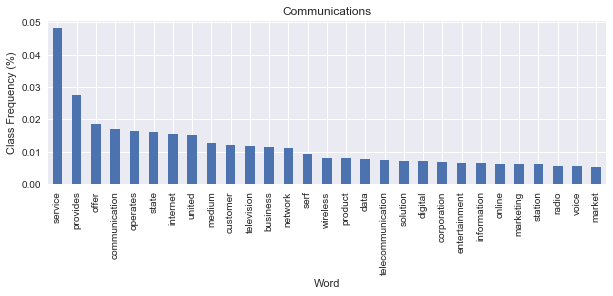

In [37]:
classLabel='Communications'
wordFrequencyCommunications=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyCommunications[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

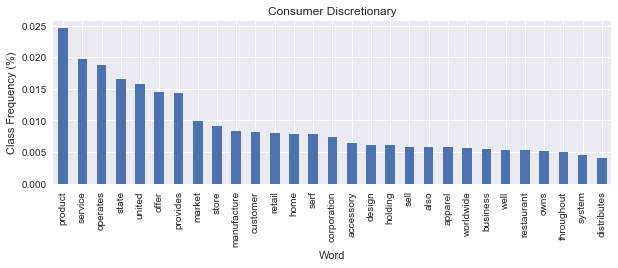

In [38]:
classLabel='Consumer Discretionary'
wordFrequencyConsumerDiscretionary=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyConsumerDiscretionary[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

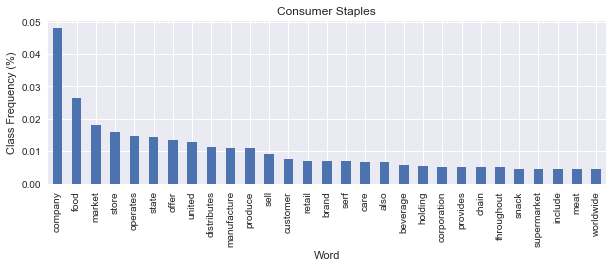

In [39]:
classLabel='Consumer Staples'
wordFrequencyConsumerStaples=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyConsumerStaples[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

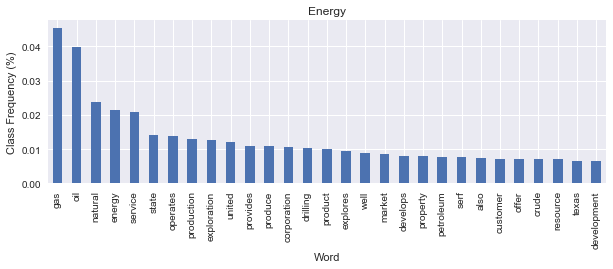

In [40]:
classLabel='Energy'
wordFrequencyEnergy=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyEnergy[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

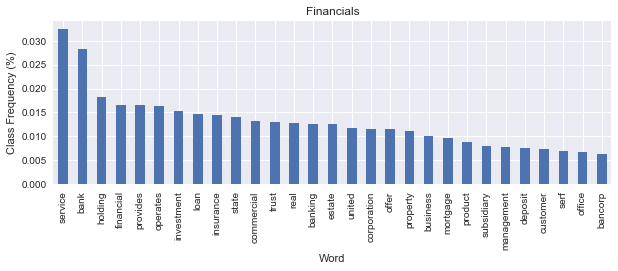

In [41]:
classLabel='Financials'
wordFrequencyFinancials=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyFinancials[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

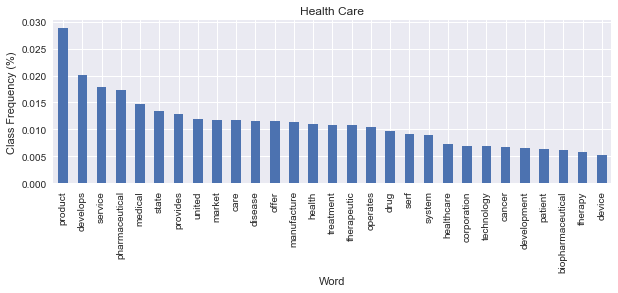

In [42]:
classLabel='Health Care'
wordFrequencyHealthCare=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyHealthCare[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

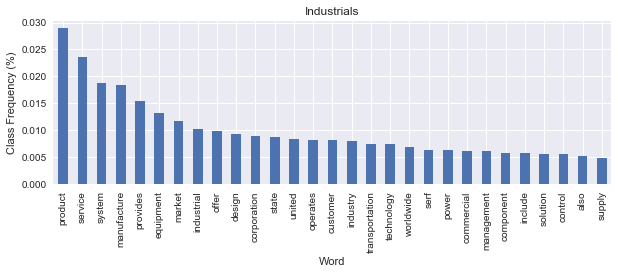

In [43]:
classLabel='Industrials'
wordFrequencyIndustrials=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyIndustrials[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

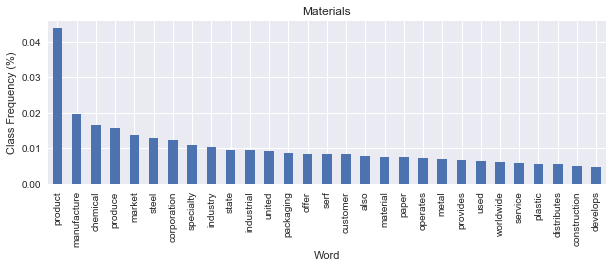

In [44]:
classLabel='Materials'
wordFrequencyMaterials=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyMaterials[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

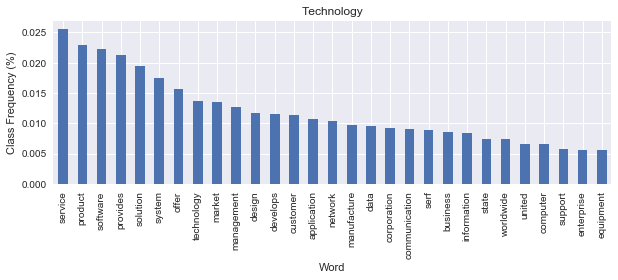

In [45]:
classLabel='Technology'
wordFrequencyTechnology=wordBySectorFrequencyPercent[classLabel].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyTechnology[1:30].plot('bar')
plt.title(classLabel)
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

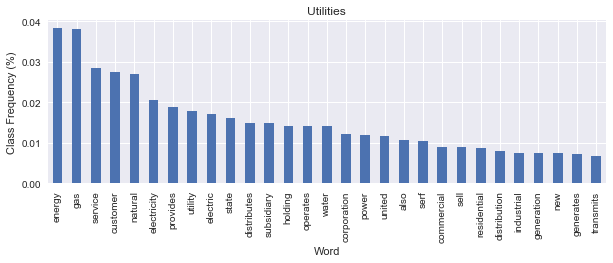

In [46]:
wordFrequencyUtilities=wordBySectorFrequencyPercent['Utilities'].sort_values(ascending=False)
plt.figure(figsize=(10,3))
wordFrequencyUtilities[1:30].plot('bar')
plt.title('Utilities')
plt.ylabel("Class Frequency (%)")
plt.xlabel("Word")

Notice that some words appear in the descriptions of companies across all classes:

After examining the most common words in the company descriptions of each sector, it is clear that some words are commonly used in all company descriptions irrespective of sector.

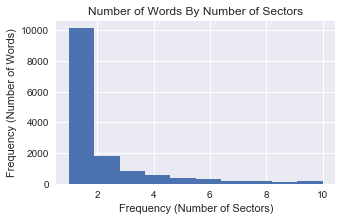

In [47]:

plt.figure(figsize=(5,3))
flagRowTotals.plot('hist')
plt.title('Number of Words By Number of Sectors')
plt.ylabel("Frequency (Number of Words)")
plt.xlabel("Frequency (Number of Sectors)")

In the above histogram plot, we can see that there are some words that appear in the descriptions of companies across all classes (i.e., we find the word in all 10 sectors), even after the removal of common stopwords. We would expect that words that are used to describe all companies will not improve our classifiers much.

In [48]:
# join high frequency words with number of sectors in which they appear
commonWordsInAllSectors=pandas.concat([allWordsByFrequency,
    flagRowTotals], axis=1, join='inner', ignore_index=False)
# define column names
columnNames={0 : 'wordFrequencyPercent',1 : 'nSectors'}
# rename column names
commonWordsInAllSectors.rename(columns=columnNames,inplace=True)
# sort
mostCommonWordsInAllSectors=commonWordsInAllSectors.sort_values(by=['wordFrequencyPercent',
    'nSectors'],ascending=False)
# display top 20
mostCommonWordsInAllSectors.head(20)

,wordFrequencyPercent,nSectors
word,,
company,0.047362,10
service,0.024700,10
product,0.021294,10
provides,0.016136,10
state,0.012735,10
offer,0.012578,10
operates,0.012511,10
united,0.011357,10
market,0.009885,10


Focusing on the 20 most common words, we examine the relative frequencies within each sector:

In [49]:
#
commonWordIndex=mostCommonWordsInAllSectors.index[0:7]
#
wordBySectorFrequencyPercent.loc[commonWordIndex].T

word,company,service,product,provides,state,offer,operates
bicsSector,,,,,,,
Communications,0.050196,0.048139,0.007857,0.027499,0.016025,0.018457,0.016213
Consumer Discretionary,0.043326,0.019788,0.024573,0.014421,0.016587,0.014518,0.018818
Consumer Staples,0.047904,0.004277,0.048637,0.005255,0.014542,0.013320,0.014787
Energy,0.054362,0.020895,0.010023,0.010957,0.014185,0.007135,0.013930
Financials,0.049889,0.032545,0.008903,0.016491,0.014093,0.011532,0.016445
Health Care,0.052655,0.017880,0.028826,0.012917,0.013495,0.011626,0.010402
Industrials,0.041768,0.023535,0.028889,0.015404,0.008788,0.009798,0.008232
Materials,0.045758,0.005955,0.043774,0.006791,0.009611,0.008358,0.007104
Technology,0.040666,0.025614,0.022837,0.021340,0.007485,0.015679,0.005172


The words 'company', 'service', 'product', 'provides', 'state', 'offer', 'operates', 'united', and 'corporation' are commonly found in the descriptions of all companies regardless of sector classification.

However, 'Communications' and 'Technology' company descriptions contain the word 'customer' more frequently.

In [50]:
#
commonWordIndex=mostCommonWordsInAllSectors.index[7:14]
#
wordBySectorFrequencyPercent.loc[commonWordIndex].T

word,united,market,corporation,customer,serf,manufacture,system
bicsSector,,,,,,,
Communications,0.015215,0.005238,0.006859,0.011910,0.009104,0.000374,0.004365
Consumer Discretionary,0.015811,0.009862,0.007437,0.008213,0.007922,0.008342,0.004559
Consumer Staples,0.012709,0.017964,0.005255,0.007699,0.006843,0.011121,0.000367
Energy,0.012231,0.008664,0.010533,0.007220,0.007730,0.003992,0.003822
Financials,0.011648,0.005028,0.011532,0.007312,0.006919,0.000069,0.000623
Health Care,0.011999,0.011762,0.006867,0.004521,0.009110,0.011422,0.008906
Industrials,0.008333,0.011667,0.008889,0.008131,0.006364,0.018384,0.018737
Materials,0.009298,0.013581,0.012223,0.008253,0.008358,0.019536,0.004179
Technology,0.006614,0.013501,0.009228,0.011351,0.008819,0.009636,0.017530


The word, 'market', is most commonly used to describe 'Financial' companies.

The words 'develops' and 'system' are most frequently found in the descriptions of 'Technology' and 'Health Care' companies.

In [51]:
#
commonWordIndex=mostCommonWordsInAllSectors.index[14:20]
#
wordBySectorFrequencyPercent.loc[commonWordIndex].T

word,develops,holding,business,management,bank,solution
bicsSector,,,,,,
Communications,0.002681,0.004614,0.011349,0.002744,0.000374,0.007109
Consumer Discretionary,0.002813,0.006046,0.005432,0.003557,0.000194,0.002554
Consumer Staples,0.002077,0.005499,0.002566,0.000978,0.000000,0.000122
Energy,0.008154,0.002378,0.001699,0.002124,0.000000,0.003143
Financials,0.002076,0.018313,0.009987,0.007773,0.028278,0.001407
Health Care,0.020090,0.002312,0.001870,0.004249,0.000034,0.002481
Industrials,0.004091,0.003788,0.002121,0.006010,0.000000,0.005505
Materials,0.004806,0.003448,0.002821,0.001149,0.000000,0.003134
Technology,0.011568,0.001851,0.008493,0.012657,0.000218,0.019462


Notice that financial and utility company descriptions contain the word, 'holding' more often than the other sectors. The word, 'bank', is far more frequent in the descriptions of financial companies. Unsurprisingly, the words, 'technology' and 'solution', are more often found in the descriptions of companies in the 'Technology' sector.

In the next section we use the features developed above to develop a set of classifiers to predict sector based on company description.

## Classifier Development

The following set of functions are used to train and evaluate different types of classifiers based on the bag of words and the bag of words plus bigrams feature sets developed above in the feature engineering section:

In [199]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(20,20))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

# 
def evaluateNaiveBayesClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(trainFeatureSet) 
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier

def evaluateDecisionTreeClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier 
    classifier = nltk.DecisionTreeClassifier.train(trainFeatureSet, binary=True, 
        depth_cutoff=20, support_cutoff=20, entropy_cutoff=0.01) 
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier

def evaluateMaxentClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier (use General Iterative Scaling)
    classifier = nltk.MaxentClassifier.train(trainFeatureSet, algorithm='gis', 
        trace=0, max_iter=20, min_lldelta=0.5) 
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier

def evaluateMultinomialNBClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier    
    classifier = SklearnClassifier(MultinomialNB())
    classifier.train(trainFeatureSet)    
    
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier

def evaluateLogisticRegressionClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier    
    classifier = SklearnClassifier(LogisticRegression())
    classifier.train(trainFeatureSet)    
    
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier

def evaluateFinalLogisticRegressionClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier    
    classifier = SklearnClassifier(LogisticRegression())
    classifier.train(trainFeatureSet)    
    
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    # compute accuracy (final test set)
    testAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)     
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    # copy development test data set
    testSetPredictions=dfTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    testSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    testSetPredictions['classifierBicsSector']=testSetPredictions[wordType].apply(fClassify) 
    
    testSetPredictionsList=testSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    testSetGoldList = [g  for (n, g) in testFeatureSet]
    # create confusion matrix
    testCm=confusion_matrix(testSetGoldList, testSetPredictionsList)
    # get unique classes (train)
    testLabelNames =  list(set(testSetGoldList) | set(testSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    testReport=classification_report(testSetGoldList, testSetPredictionsList,
        digits=display_digits)      
    
    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,testAccuracy,testCm,testReport,classifier

def evaluateLinearSVCClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW'):

    # map bag of words training feature set and BICS sector into 
    # list of tuples
    trainFeatureSet=list(dfTrain[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    devTestFeatureSet=list(dfDevTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    # map bag of words developement testing feature set and BICS 
    # sector into list of tuples
    testFeatureSet=list(dfTest[[wordType,
        'bicsSector']].itertuples(index=False, name=None))
    
    # build classifier    
    classifier = SklearnClassifier(LinearSVC())
    classifier.train(trainFeatureSet)
    
    # compute accuracy (train set)
    trainAccuracy=nltk.classify.accuracy(classifier, trainFeatureSet)
    # compute accuracy (development test set)
    devTestAccuracy=nltk.classify.accuracy(classifier, devTestFeatureSet)    
    
    # copy training data set
    trainSetPredictions=dfTrain.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    trainSetPredictions.drop(labels=columnNames,axis=1,inplace=True)
    # create predicted classes (train)
    fClassify=lambda d : classifier.classify(d)
    # add sector (BICS) predicted by classifier
    trainSetPredictions['classifierBicsSector']=trainSetPredictions[wordType].apply(fClassify) 
    
    trainSetPredictionsList=trainSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    trainSetGoldList = [g  for (n, g) in trainFeatureSet]
    # create confusion matrix
    trainCm=confusion_matrix(trainSetGoldList, trainSetPredictionsList)
    # get unique classes (train)
    trainLabelNames =  list(set(trainSetGoldList) | set(trainSetPredictionsList))    
    # create table with precision, recall, f1-score, and support
    trainReport=classification_report(trainSetGoldList, trainSetPredictionsList,
        digits=display_digits)

    # copy development test data set
    devTestSetPredictions=dfDevTest.copy()
    # define columns to drop
    columnNames=['nWords','nSetWords','nWordsStemmed','nSetWordsStemmed','nWordsLemmatized',
        'nSetWordsLemmatized']
    # drop columns
    devTestSetPredictions.drop(labels=columnNames,axis=1,inplace=True)

    # add sector (BICS) predicted by classifier
    devTestSetPredictions['classifierBicsSector']=devTestSetPredictions[wordType].apply(fClassify) 
    
    devTestSetPredictionsList=devTestSetPredictions['classifierBicsSector'].tolist()
    # extract actual classes (gold)
    devTestSetGoldList = [g  for (n, g) in devTestFeatureSet]
    # create confusion matrix
    devTestCm=confusion_matrix(devTestSetGoldList, devTestSetPredictionsList)
    # get unique classes (train)
    devTestLabelNames =  list(set(devTestSetGoldList) | set(devTestSetPredictionsList))  
    # create table with precision, recall, f1-score, and support
    devTestReport=classification_report(devTestSetGoldList, devTestSetPredictionsList,
        digits=display_digits)    

    return trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,classifier


### Bag of Words

In this section, we train and test a number of different types of classifers using the simple bag of words (BOW) feature set constructed above in the feature engineering section.

#### Naive Bayes Classifier

Naive Bayes is a notoriously good baseline classifier.

For document (i.e., company description) $d$ and a class $c$

Bayes law:

$$P(c|d)=\frac{P(d \mid c)P(c)}{P(d)}$$

The maximum a posteriori (MAP) - that is, the most likely - class is given by:

$$c_{MAP}=\text{arg}\max\limits_{c \in C}P(c \mid d)$$

By Bayes rule:

$$c_{MAP}=\text{arg}\max\limits_{c \in C}\frac{P(d \mid c)P(c)}{P(d)}$$

We can simplify, by dropping the $P(d)$ in the donominator (because it is a normalizing constant):

$$c_{MAP}=\text{arg}\max\limits_{c \in C}P(d \mid c)P(c)$$

We represent the document, $d$, as a set of features ($x_{1},x_{2},\dots,x_{n}$):

$$c_{MAP}=\text{arg}\max\limits_{c \in C}P(x_{1},x_{2},\dots,x_{n} \mid c)P(c)$$

How do we compute the probability of a class, $c$? We are really just asking 'How often does this class occur?' Computing the probability of a class, $P(c)$ is really just a count of the relative frequency of each class in a corpus of documents.

Without some simplifying assumptions, the number of parameters is huge. We would need a very, very large number of training examples to estimate these parameters reliably. We make the following simplifying assumptions to make this more tractable:

(1) Assume the position in the document does not matter (often referred to as the 'bag of words assumption')

(2) Assume that the feature probabilities $P(x_{i} \mid c_{j})$ are independent given the class $c$.

Allows us to solve the problem with a high degree of accuracy without needing an enormous data set for training/estimation.

We represent the join probability given a class as:

$$P(x_{1},x_{2},\dots,x_{n} \mid c)=P(x_{1} \mid c) \times P(x_{2} \mid c) \times P(x_{3} \mid c) \times \dots \times P(x_{n} \mid c)$$

To compute the most likely 

$$c_{MAP}=\text{arg}\max\limits_{c \in C}P(x_{1},x_{2},\dots,x_{n} \mid c)P(c)$$

For the general Navie Bayes classifier:

$$c_{NB}=\text{arg}\max\limits_{c \in C}P(c_{j})\prod_{x \in X} P(x \mid c)$$

The most likely class, $c$, maximizes the prior probability of the class, $P(c_{j})$ multiplied by the product of each probability for each feature, $x$, given the class, $c$ (i.e., $P(x_{i} \mid c_{j})$).

More specifically, for text classification:

$$c_{NB}=\text{arg}\max\limits_{c_{j} \in C}P(c_{j})\prod_{i \in I} P(w_{i} \mid c_{j})$$

where $w_{i}$ is the word in position, $i$, and $I$ is the set of all word positions in the test document.

##### Parameter Estimation: Laplace (add-1) Smoothing

We estimate the $P(w_{i} \mid c)$ as:

$$\hat{P}(w_{i} \mid c)=\frac{count(w_{i},c)+1}{\sum_{w \in V} (count(w,c)+1)}$$

Equivalently, we can re-write the above equation with vocabulary size, $V$, as:

$$\hat{P}(w_{i} \mid c)=\frac{count(w_{i},c)+1}{\bigg(\sum_{w \in V} count(w,c)\bigg)+|V|}$$

where $\bigg( \sum_{w \in V} count(w,c)\bigg)$ is the total number of tokens in class, $c$.

[Address unknown words]

$\hat{P}(c)=\frac{N_{c}}{N}$

$\hat{P}(w \mid c)=\frac{count(w,c)+1}{count(c)+|V|}$

where $count(c)$ is the count of all words in class, $c$, and $count(w,c)$ is the count of word, $w$, in class, $c$.


First we train a Naive Bayes Classifier using the NLTK package:

Accuracy (Train): 0.888193421699
Accuracy (Development Test): 0.834
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.8651    0.9119    0.8879       647
Consumer Discretionary     0.9483    0.6856    0.7959      1177
      Consumer Staples     0.7059    0.9536    0.8113       302
                Energy     0.9549    0.8720    0.9116       461
            Financials     0.9652    0.9476    0.9564      1700
           Health Care     0.9781    0.9348    0.9560      1196
           Industrials     0.7733    0.8680    0.8179       727
             Materials     0.7765    0.9361    0.8489       360
            Technology     0.8849    0.9110    0.8978      1393
             Utilities     0.6345    0.9946    0.7747       185

           avg / total     0.8998    0.8882    0.8885      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

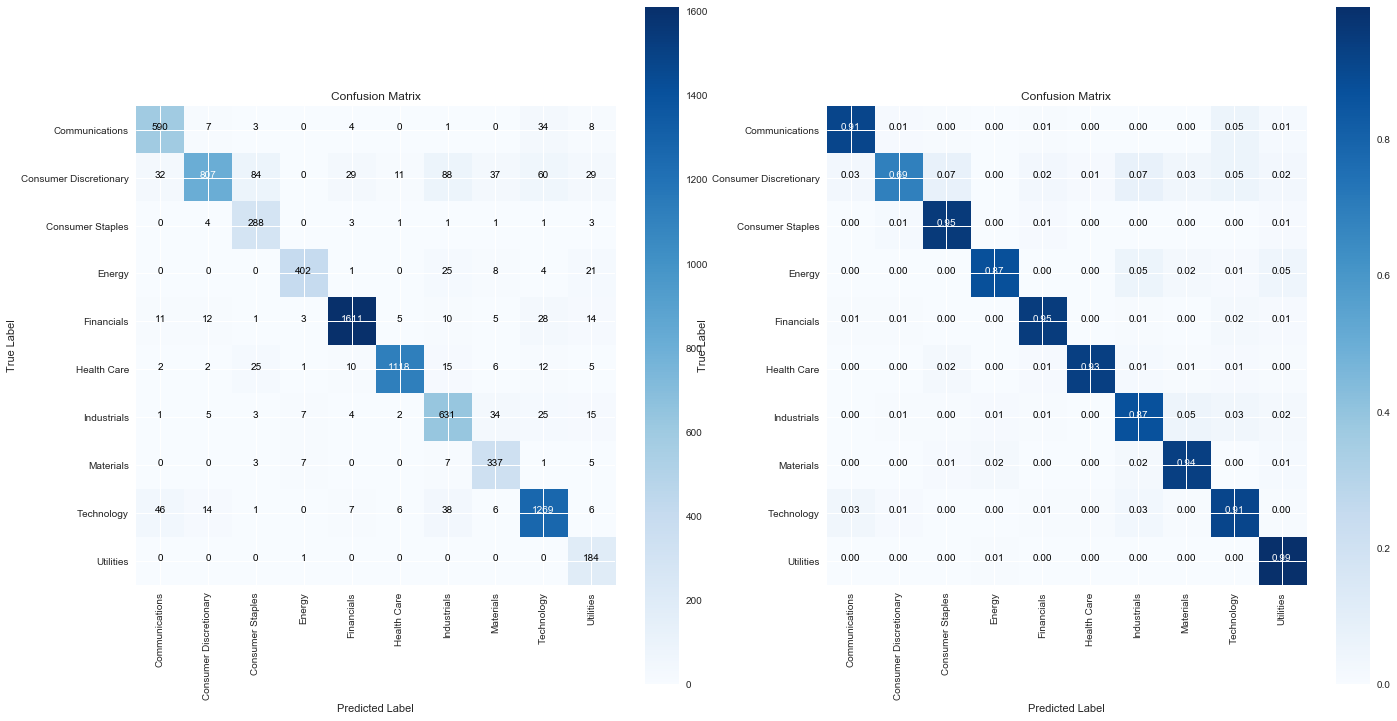

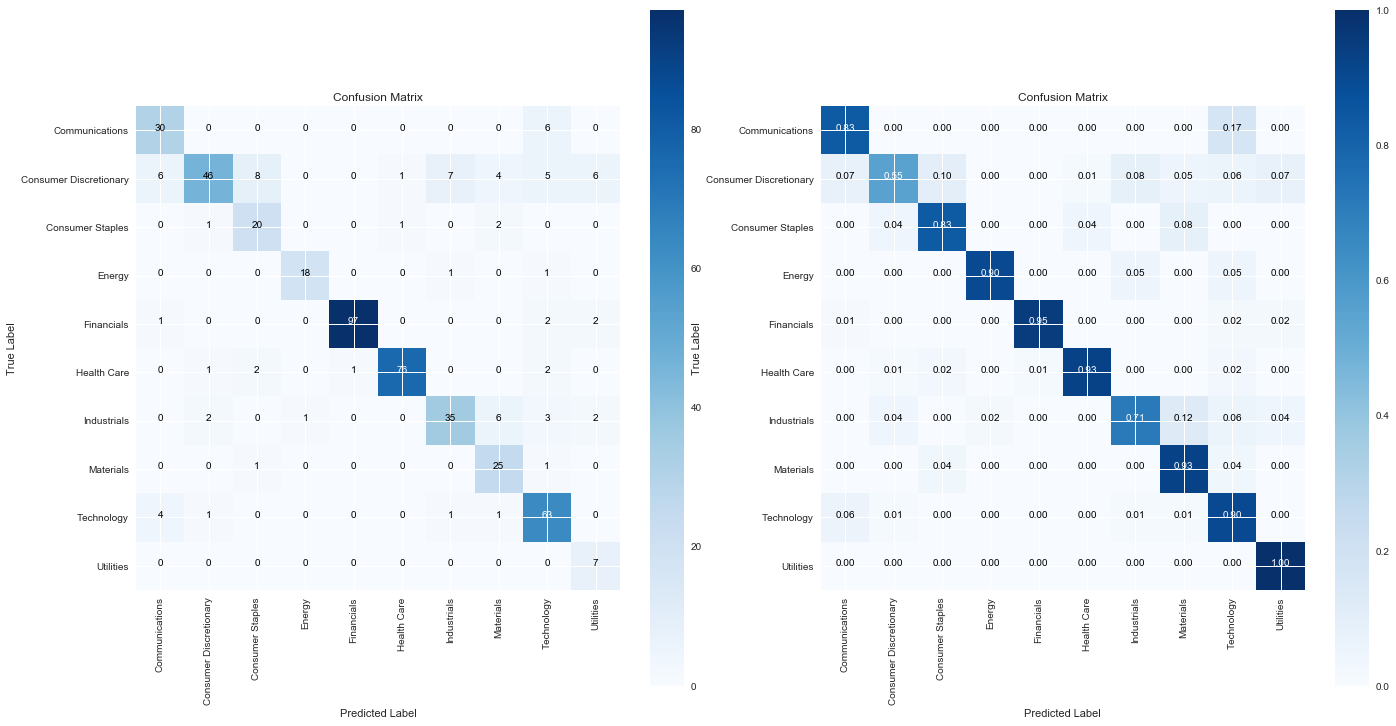

In [192]:
# NLTK
trainAccuracyNbBOW,trainCmNbBOW,trainReportNbBOW,devTestAccuracyNbBOW,devTestCmNbBOW,devTestReportNbBOW,classifierNbBOW=evaluateNaiveBayesClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracyNbBOW))
print('Accuracy (Development Test): '+str(devTestAccuracyNbBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmNbBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmNbBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportNbBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportNbBOW)

We can view the most informative features as follows:

In [77]:
classifierNbBOW.show_most_informative_features(n=200)

Most Informative Features
                     oil = True           Energy : Techno =    630.6 : 1.0
                     gas = True           Energy : Health =    557.0 : 1.0
             electricity = True           Utilit : Financ =    490.8 : 1.0
                    food = True           Consum : Financ =    454.7 : 1.0
                electric = True           Utilit : Financ =    362.8 : 1.0
          pharmaceutical = True           Health : Financ =    320.7 : 1.0
                chemical = True           Materi : Financ =    312.6 : 1.0
                    bank = True           Financ : Health =    295.3 : 1.0
                 natural = True           Utilit : Techno =    274.3 : 1.0
               treatment = True           Health : Financ =    273.3 : 1.0
                explores = True           Energy : Financ =    268.8 : 1.0
             exploration = True           Energy : Techno =    256.5 : 1.0
                internet = True           Commun : Health =    238.3 : 1.0

#### Multinomial Naive Bayes Classifier

Next we use the scikit-learn package to train and test a Multinomial Naive Bayes classifier:

Accuracy (Train): 0.876656848306
Accuracy (Development Test): 0.802
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9578    0.7713    0.8545       647
Consumer Discretionary     0.8540    0.8003    0.8263      1177
      Consumer Staples     0.9812    0.6921    0.8117       302
                Energy     0.8685    0.8742    0.8714       461
            Financials     0.9156    0.9641    0.9393      1700
           Health Care     0.9628    0.9515    0.9571      1196
           Industrials     0.7590    0.8102    0.7838       727
             Materials     0.9418    0.7194    0.8157       360
            Technology     0.7901    0.9648    0.8688      1393
             Utilities     0.9837    0.6541    0.7857       185

           avg / total     0.8840    0.8767    0.8754      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

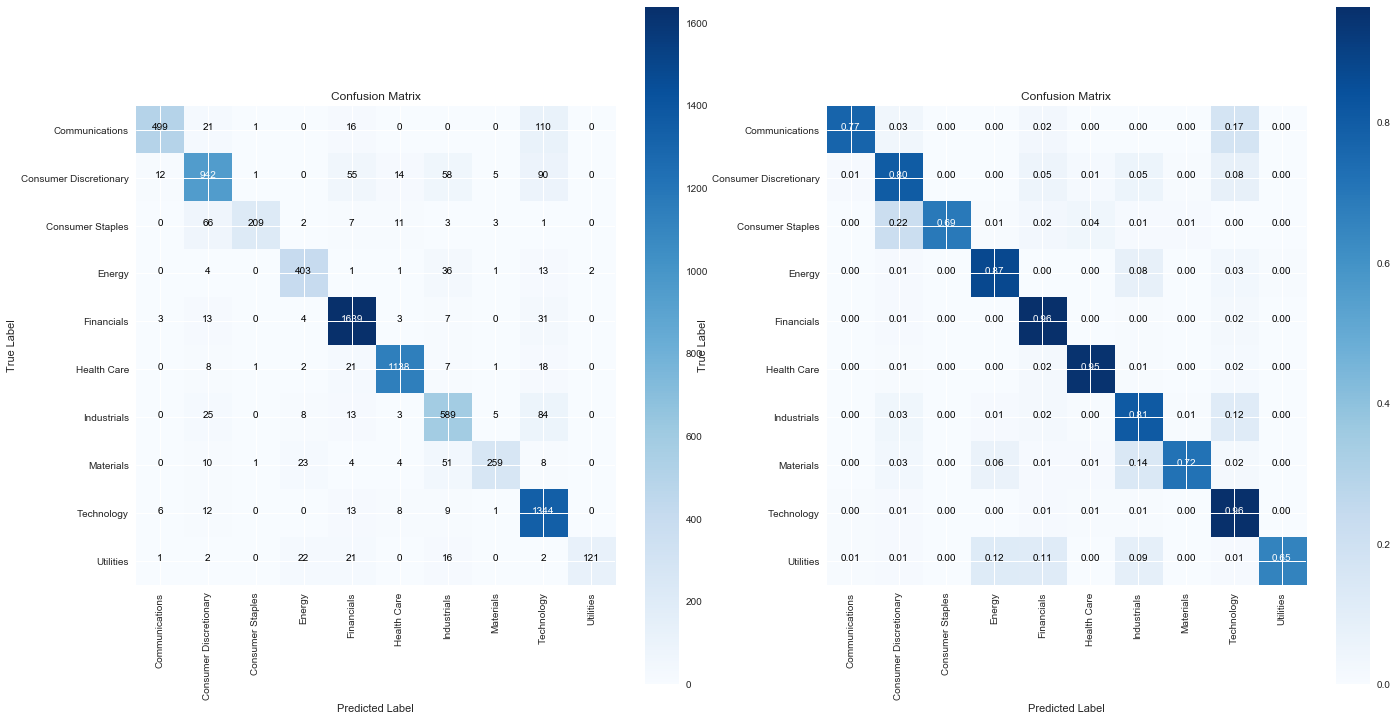

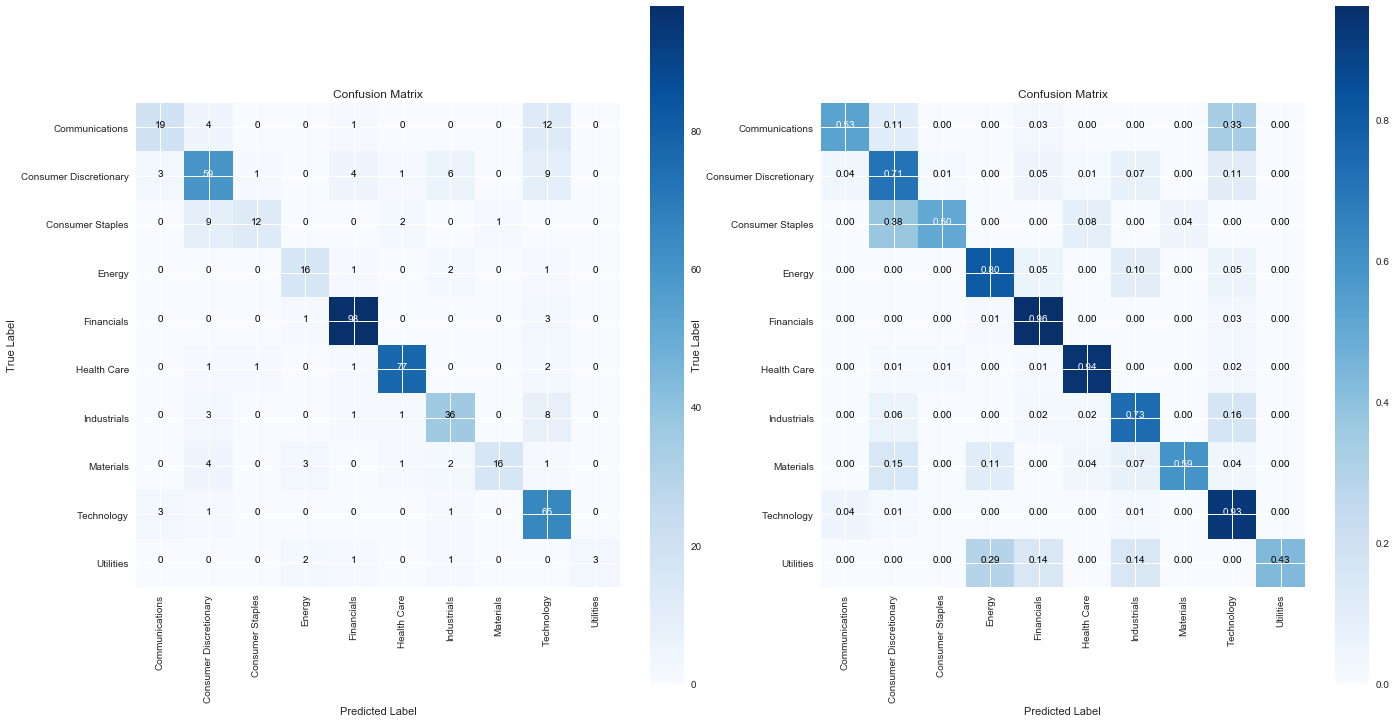

In [193]:
# scikit-learn
trainAccuracySkNbBOW,trainCmSkNbBOW,trainReportSkNbBOW,devTestAccuracySkNbBOW,devTestCmSkNbBOW,devTestReportSkNbBOW,classifierSkNbBOW=evaluateMultinomialNBClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkNbBOW))
print('Accuracy (Development Test): '+str(devTestAccuracySkNbBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkNbBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkNbBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkNbBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkNbBOW)

Both Naive Bayes classifiers perform surprisingly well. The NLTK implementation performs better than the scikit-learn implementation in this case with an f1-score of 0.889 in-sample and 0.834 out-of-sample. The scikit-learn performance is slightly worse with an in-sample f1-score of 0.875 and an out-of-sample f1-score of 0.797. These two classifiers provide a code baseline for the evaluation of other classifiers.

#### Decision Tree Classifier

We train and test a Decision Tree classifier as follows:

Accuracy (Train): 0.744231713304
Accuracy (Development Test): 0.632
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.8674    0.5966    0.7070       647
Consumer Discretionary     0.8380    0.5055    0.6306      1177
      Consumer Staples     0.9278    0.5530    0.6929       302
                Energy     0.9724    0.7636    0.8554       461
            Financials     0.6044    0.9535    0.7398      1700
           Health Care     0.8371    0.8462    0.8416      1196
           Industrials     0.6475    0.6039    0.6249       727
             Materials     0.7510    0.5111    0.6083       360
            Technology     0.7844    0.8385    0.8105      1393
             Utilities     0.9459    0.7568    0.8408       185

           avg / total     0.7748    0.7442    0.7395      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

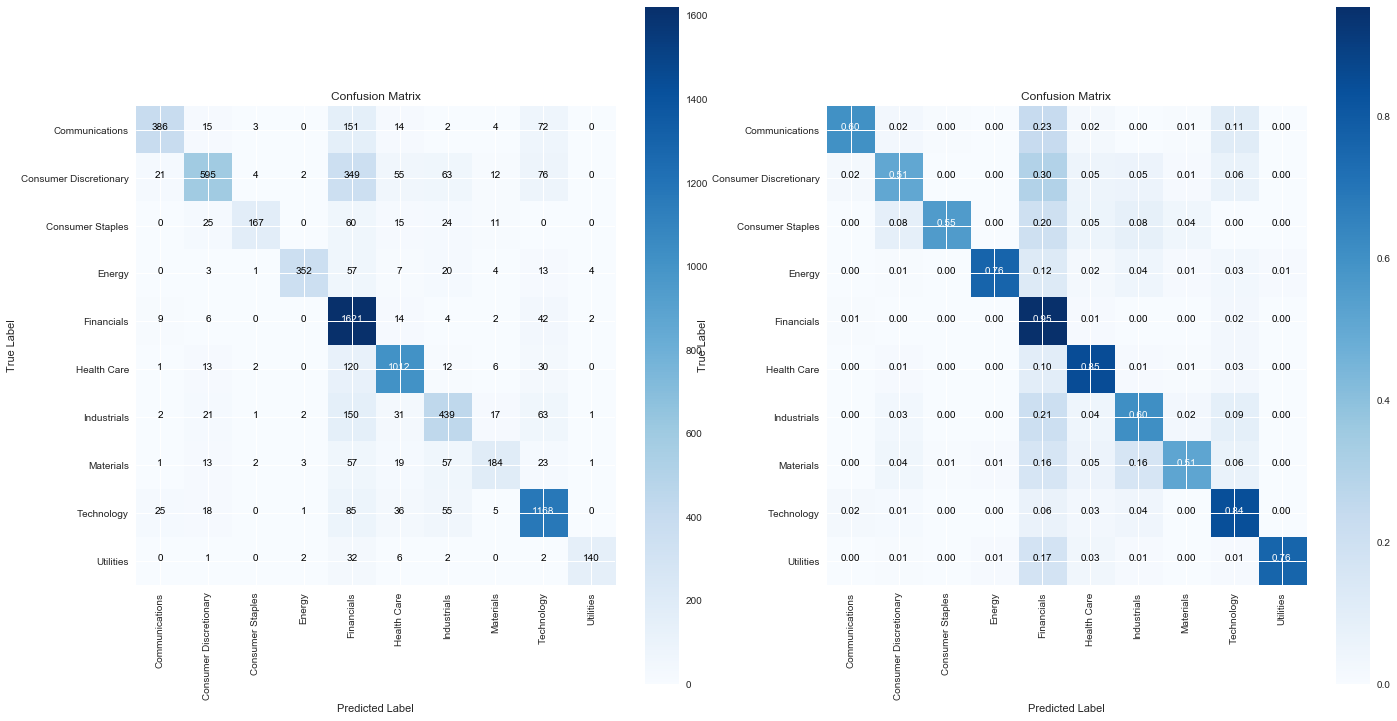

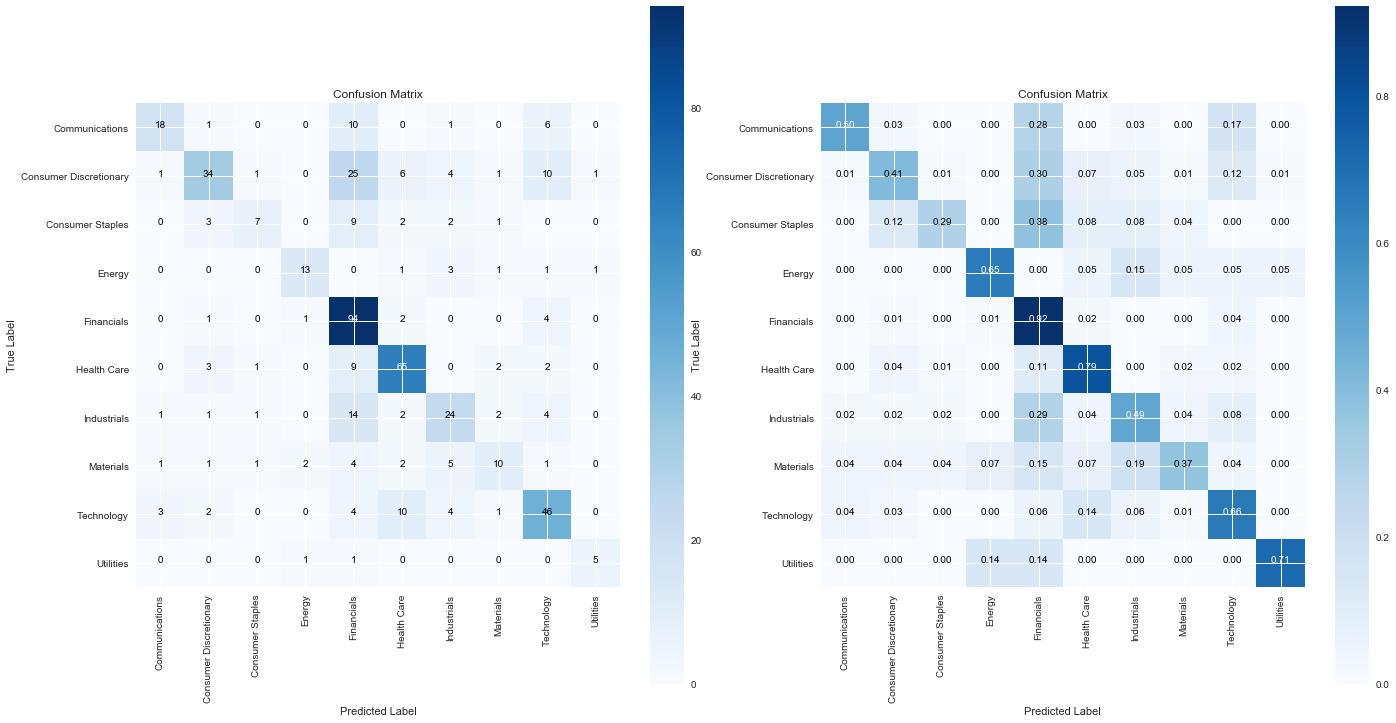

In [190]:
# NLTK
trainAccuracyDtBOW,trainCmDtBOW,trainReportDtBOW,devTestAccuracyDtBOW,devTestCmDtBOW,devTestReportDtBOW,classifierDtBOW=evaluateDecisionTreeClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')

# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracyDtBOW))
print('Accuracy (Development Test): '+str(devTestAccuracyDtBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmDtBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmDtBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportDtBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportDtBOW)

The performance of the Decision Tree classifier is relatively poor with an in-sample f1-score near 0.74 as compared to an out-of-sample score close to 0.6. Recall is particularly low for the Consumer Discretionary, Consumer Staples, and Materials sectors. Closer examination of the training and development test confusion matrices hints at a problem with unbalanced data, with the trained classifier frequently mistakenly classifying companies as 'Financial'. Application of a balanced sampling approach to the training/test split might improve our results with this type of classifier.

##### Maxent (Conditional Exponential or Logistic Regression) Classifier 

We test two logistic regression classifiers, one using the implementation in the NLTK package and the other using the implementation in the scikit-learn package.

First we train and test a logistic regression classifier using the NLTK package:

Accuracy (Train): 0.788168875798
Accuracy (Development Test): 0.718
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9915    0.3617    0.5300       647
Consumer Discretionary     0.7100    0.8258    0.7636      1177
      Consumer Staples     1.0000    0.3212    0.4862       302
                Energy     0.9213    0.7614    0.8337       461
            Financials     0.8147    0.9776    0.8888      1700
           Health Care     0.9556    0.9365    0.9459      1196
           Industrials     0.8042    0.6327    0.7082       727
             Materials     1.0000    0.3694    0.5396       360
            Technology     0.6439    0.9799    0.7771      1393
             Utilities     1.0000    0.1514    0.2629       185

           avg / total     0.8295    0.7882    0.7677      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

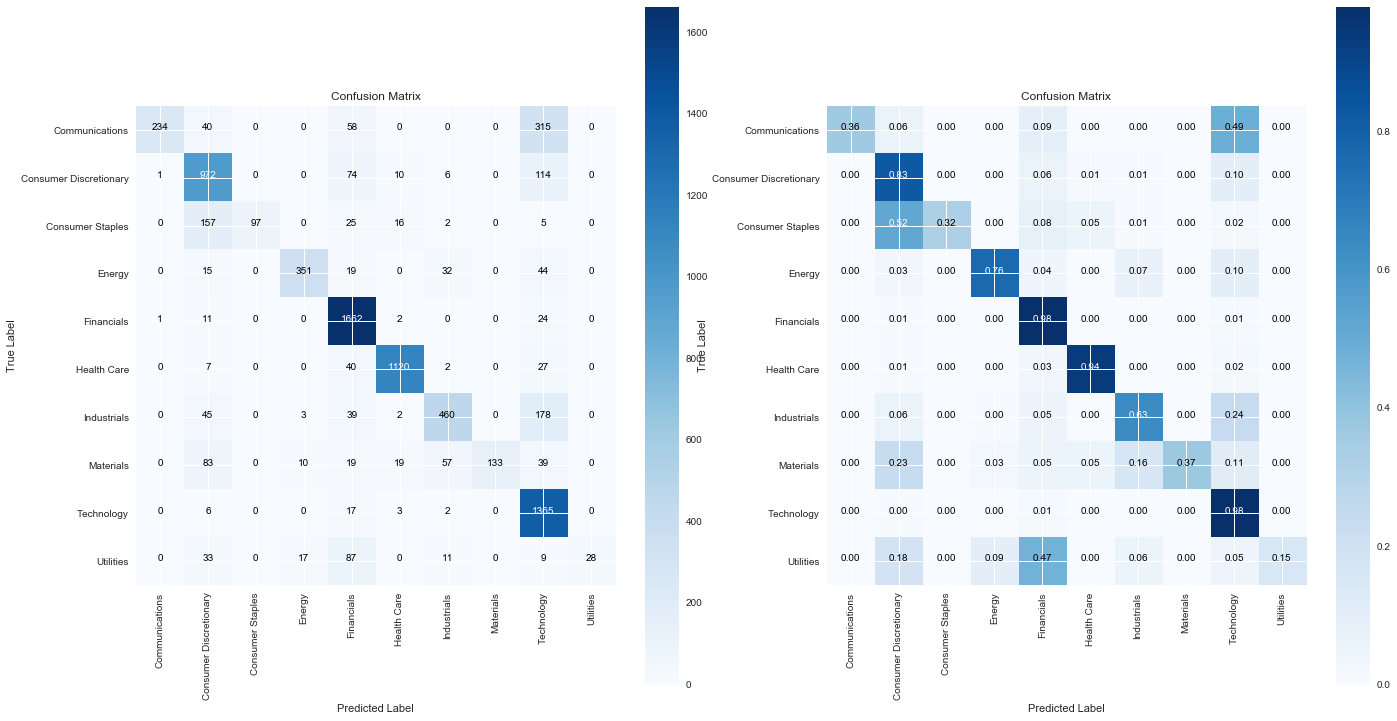

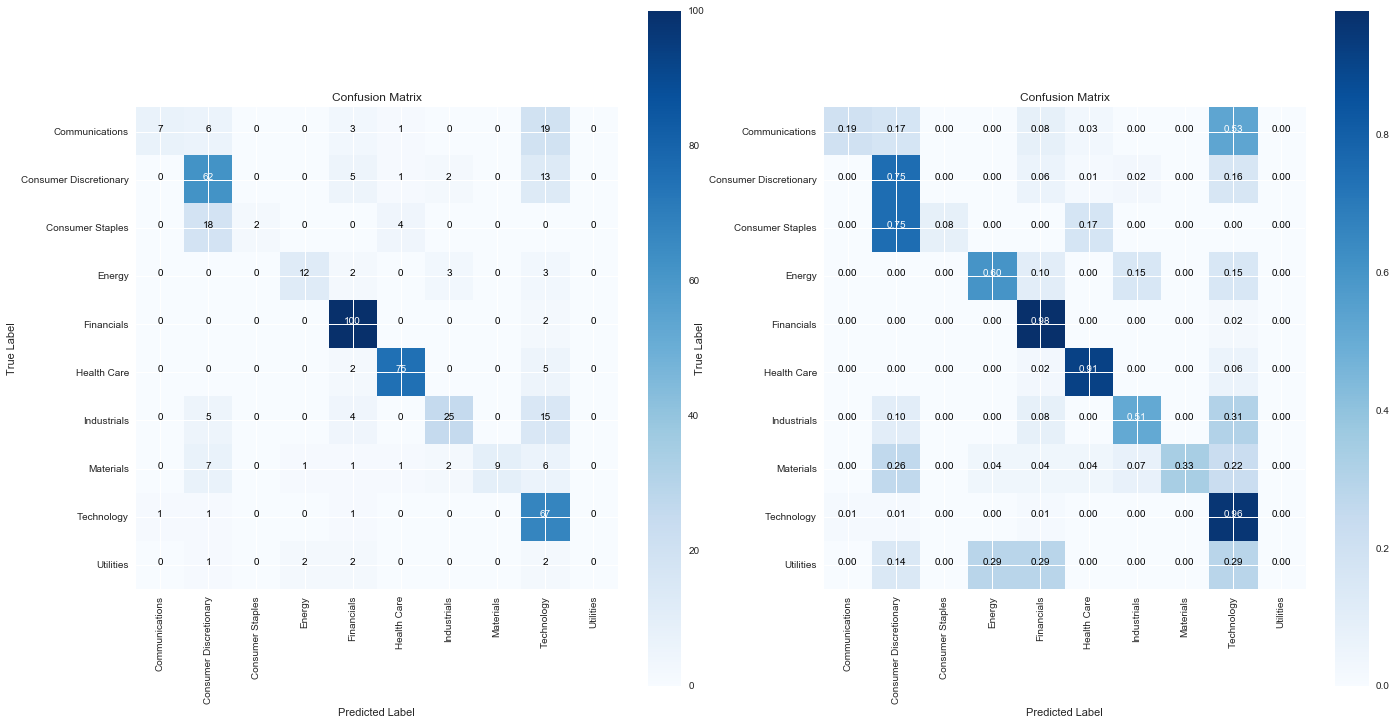

In [177]:
# NLTK classifier
trainAccuracyMeGisBOW,trainCmMeGisBOW,trainReportMeGisBOW,devTestAccuracyMeGisBOW,devTestCmMeGisBOW,devTestReportMeGisBOW,classifierMeGisBOW=evaluateMaxentClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')

# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracyMeGisBOW))
print('Accuracy (Development Test): '+str(devTestAccuracyMeGisBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmMeGisBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmMeGisBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportMeGisBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportMeGisBOW)

Performance of the NLTK Maxent classifier is relatively poor with an f1-score of 0.768 in training and 0.684 in test.

In [162]:
classifierMeGisBOW.show_most_informative_features(n=20)

  -0.001 solution==True and label is 'Consumer Staples'
  -0.001 design==True and label is 'Utilities'
  -0.001 manufacture==True and label is 'Utilities'
  -0.001 software==True and label is 'Materials'
  -0.001 financial==True and label is 'Energy'
  -0.001 financial==True and label is 'Materials'
  -0.001 financial==True and label is 'Utilities'
  -0.001 bank==True and label is 'Health Care'
  -0.001 bank==True and label is 'Utilities'
  -0.001 application==True and label is 'Consumer Staples'
  -0.001 gas==True and label is 'Health Care'
  -0.001 real==True and label is 'Health Care'
  -0.001 real==True and label is 'Energy'
  -0.001 estate==True and label is 'Energy'
  -0.001 manufacture==True and label is 'Financials'
  -0.001 worldwide==True and label is 'Utilities'
  -0.001 loan==True and label is 'Industrials'
  -0.001 information==True and label is 'Utilities'
  -0.001 data==True and label is 'Materials'
  -0.001 banking==True and label is 'Health Care'


Now we try the logistic regression classifier from the scikit-learn package:

Accuracy (Train): 0.98588610702
Accuracy (Development Test): 0.862
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9858    0.9645    0.9750       647
Consumer Discretionary     0.9863    0.9796    0.9829      1177
      Consumer Staples     1.0000    0.9768    0.9883       302
                Energy     0.9956    0.9913    0.9935       461
            Financials     0.9895    0.9971    0.9933      1700
           Health Care     0.9933    0.9941    0.9937      1196
           Industrials     0.9819    0.9711    0.9765       727
             Materials     1.0000    0.9917    0.9958       360
            Technology     0.9669    0.9849    0.9758      1393
             Utilities     0.9893    1.0000    0.9946       185

           avg / total     0.9860    0.9859    0.9859      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communic

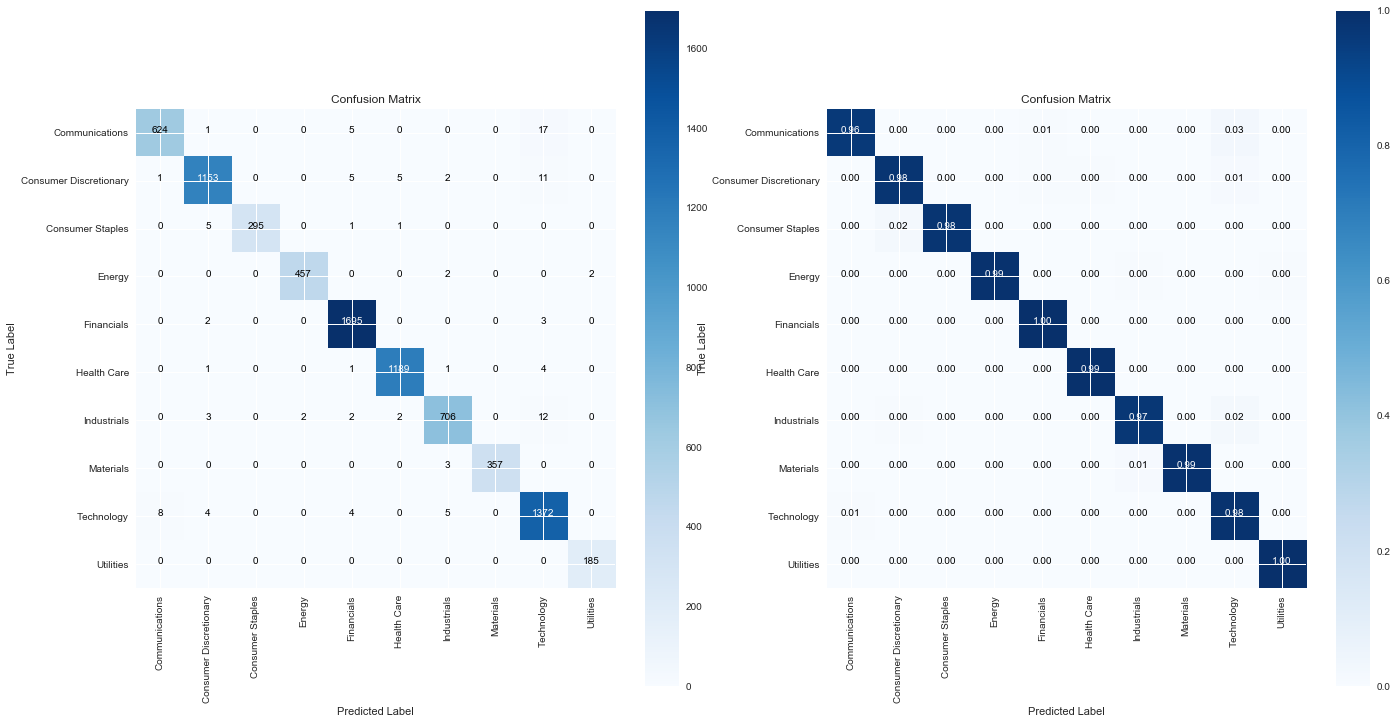

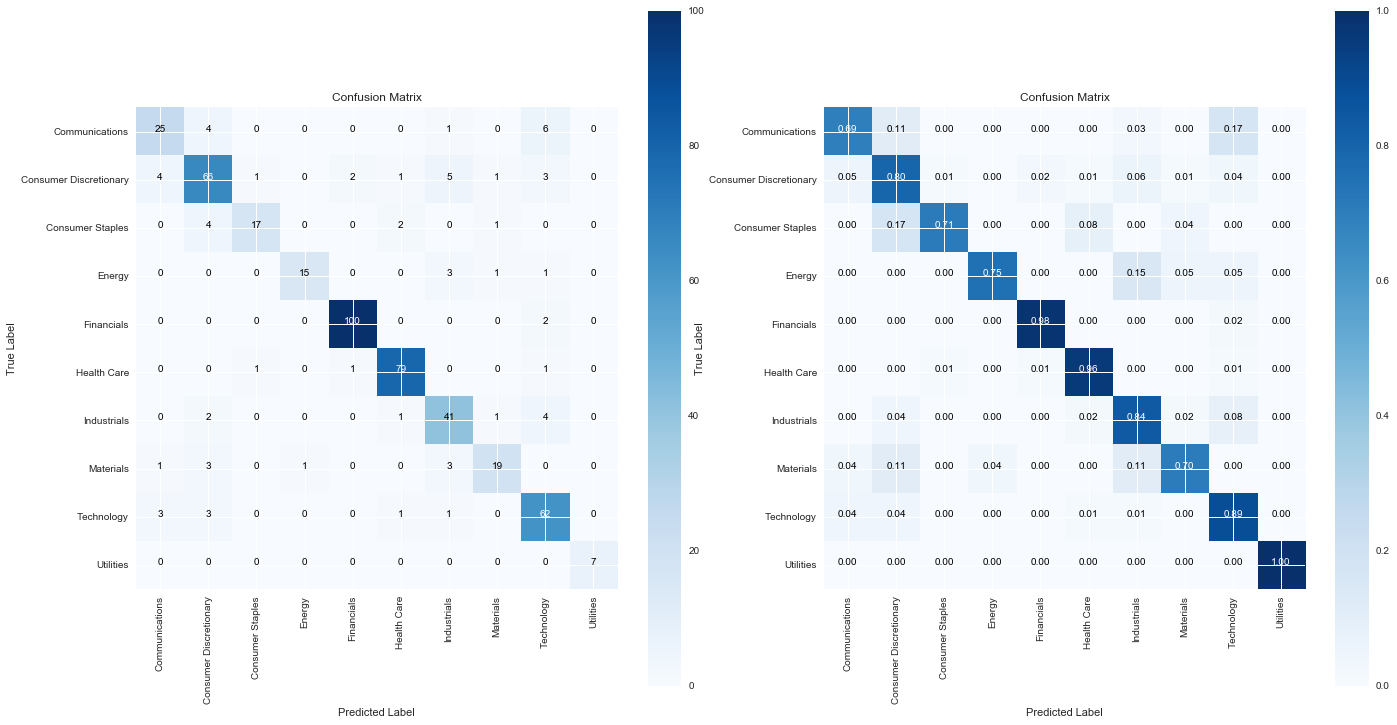

In [179]:
# scikit-learn
trainAccuracySkLrBOW,trainCmSkLrBOW,trainReportSkLrBOW,devTestAccuracySkLrBOW,devTestCmSkLrBOW,devTestReportSkLrBOW,classifierSkLrBOW=evaluateLogisticRegressionClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkLrBOW))
print('Accuracy (Development Test): '+str(devTestAccuracySkLrBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkLrBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkLrBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkLrBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkLrBOW)

Performance improves significantly over the performance of the classifer we trained and tested using the implementation in the NLTK package. 

As we move from in-sample data to out-of-sample data, we observe a significant drop in both accuracy (from 0.986 to 0.862) and f1-score (0.986 to 0.861), but the logistic regression classifier looks very promising. Precision and recall are almost perfectly balanced, despite the unbalanced representation of classes in our training and development test data sets. The performance of the precision and recall are almost perfectly balanced.

#### Linear Support Vector Classifier (SVC)

Finally, we train and test a Support Vector Classifier with a linear kernel:

Accuracy (Train): 1.0
Accuracy (Development Test): 0.834
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     1.0000    1.0000    1.0000       647
Consumer Discretionary     1.0000    1.0000    1.0000      1177
      Consumer Staples     1.0000    1.0000    1.0000       302
                Energy     1.0000    1.0000    1.0000       461
            Financials     1.0000    1.0000    1.0000      1700
           Health Care     1.0000    1.0000    1.0000      1196
           Industrials     1.0000    1.0000    1.0000       727
             Materials     1.0000    1.0000    1.0000       360
            Technology     1.0000    1.0000    1.0000      1393
             Utilities     1.0000    1.0000    1.0000       185

           avg / total     1.0000    1.0000    1.0000      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communications    

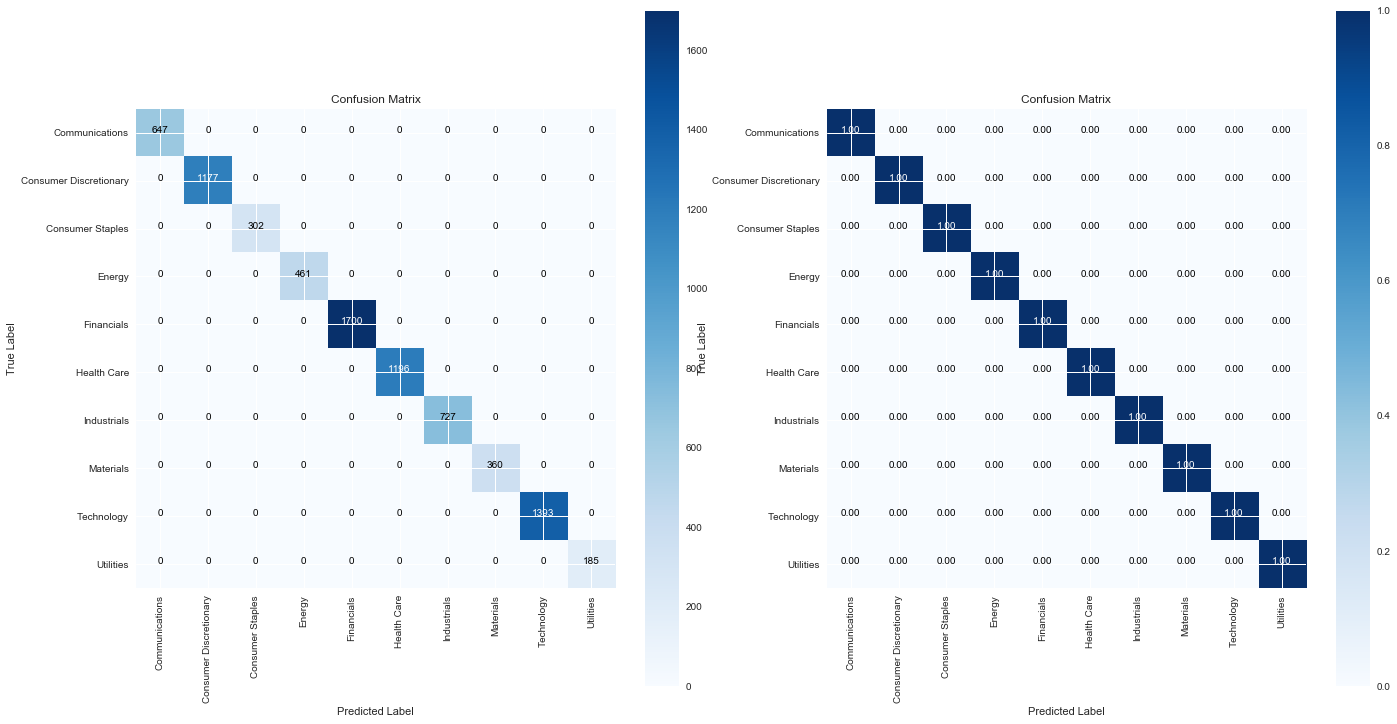

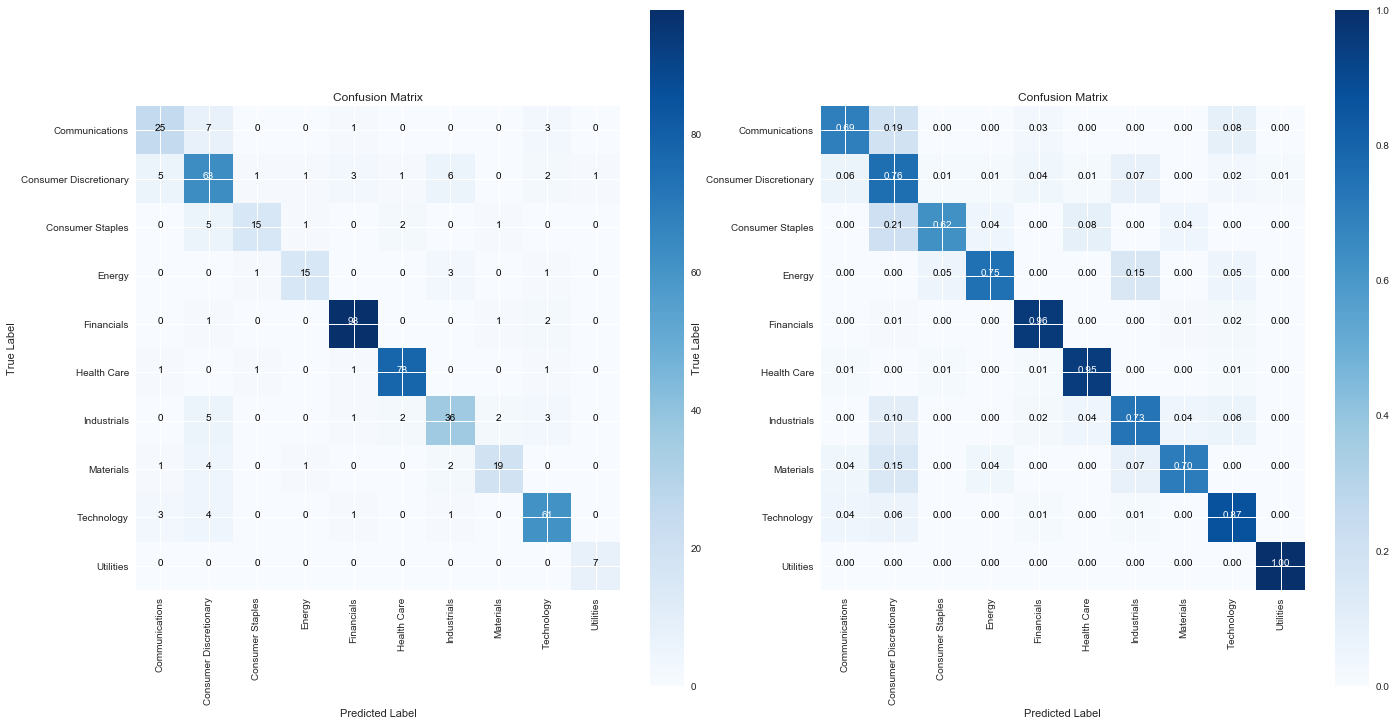

In [180]:
# scikit-learn
trainAccuracySkLsvcBOW,trainCmSkLsvcBOW,trainReportSkLsvcBOW,devTestAccuracySkLsvcBOW,devTestCmSkLsvcBOW,devTestReportSkLsvcBOW,classifierSkLsvcBOW=evaluateLinearSVCClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkLsvcBOW))
print('Accuracy (Development Test): '+str(devTestAccuracySkLsvcBOW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkLsvcBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkLsvcBOW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkLsvcBOW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkLsvcBOW)

Although development test performance is similar to that of the Naive Bayes classifier, the significant degradation when we move from training data to development test data is likely an indicator of over-fitting. Additionally, the perfect accuracy and f1-scores in training support the conclusion that this model is overfit. It may be possible to tune the features in such a way as to reduce over-fitting by focusing on the most ‘important’ features.

### Bag of Words + Bigrams

In this section, we train and test the models developed in the previous section using a feature set that contains both bag of words and bigrams.


#### Naive Bayes Classifiers

First we train and test the NLTK Naive Bayes classifier implementation:

Accuracy (Train): 0.876656848306
Accuracy (Development Test): 0.814
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9463    0.9799    0.9628       647
Consumer Discretionary     0.9972    0.6032    0.7517      1177
      Consumer Staples     0.6515    0.9967    0.7880       302
                Energy     0.9821    0.9544    0.9681       461
            Financials     0.9967    0.8776    0.9334      1700
           Health Care     0.9954    0.9114    0.9515      1196
           Industrials     0.9512    0.9120    0.9312       727
             Materials     0.7863    0.9917    0.8771       360
            Technology     0.9860    0.9124    0.9478      1393
             Utilities     0.2245    1.0000    0.3667       185

           avg / total     0.9462    0.8767    0.8956      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

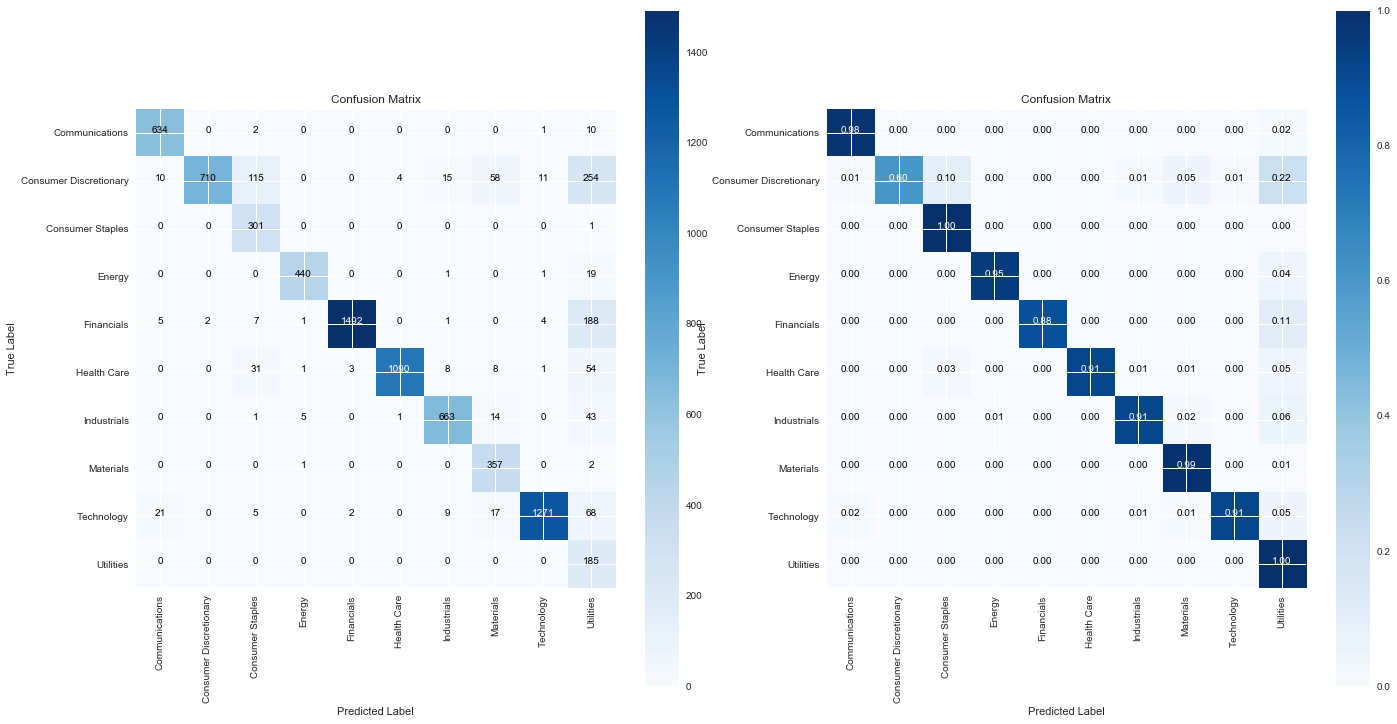

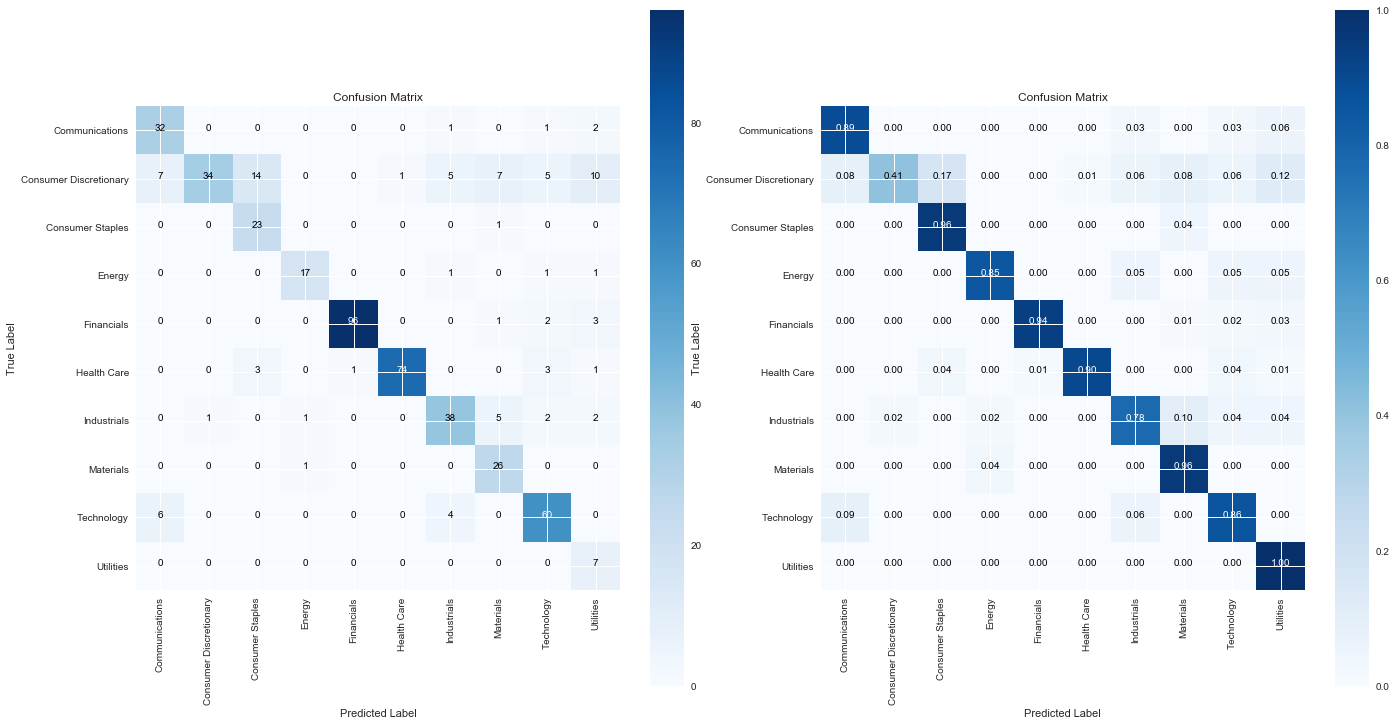

In [185]:
# NLTK
trainAccuracyNbBOBW,trainCmNbBOBW,trainReportNbBOBW,devTestAccuracyNbBOBW,devTestCmNbBOBW,devTestReportNbBOBW,classifierNbBOBW=evaluateNaiveBayesClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOBW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracyNbBOBW))
print('Accuracy (Development Test): '+str(devTestAccuracyNbBOBW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmNbBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmNbBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportNbBOBW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportNbBOBW)

Our Naive Bayes classifier model trained using our bag of words and bigrams feature set performs slightly worse than the corresponding model created using only the bag of words feature set.

Accuracy (Train): 0.95029455081
Accuracy (Development Test): 0.802
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9949    0.8980    0.9439       647
Consumer Discretionary     0.9387    0.9371    0.9379      1177
      Consumer Staples     1.0000    0.8046    0.8917       302
                Energy     0.9661    0.9284    0.9469       461
            Financials     0.9530    0.9906    0.9714      1700
           Health Care     0.9833    0.9841    0.9837      1196
           Industrials     0.9366    0.9147    0.9255       727
             Materials     1.0000    0.8917    0.9427       360
            Technology     0.8920    0.9907    0.9388      1393
             Utilities     1.0000    0.8703    0.9306       185

           avg / total     0.9525    0.9503    0.9500      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communic

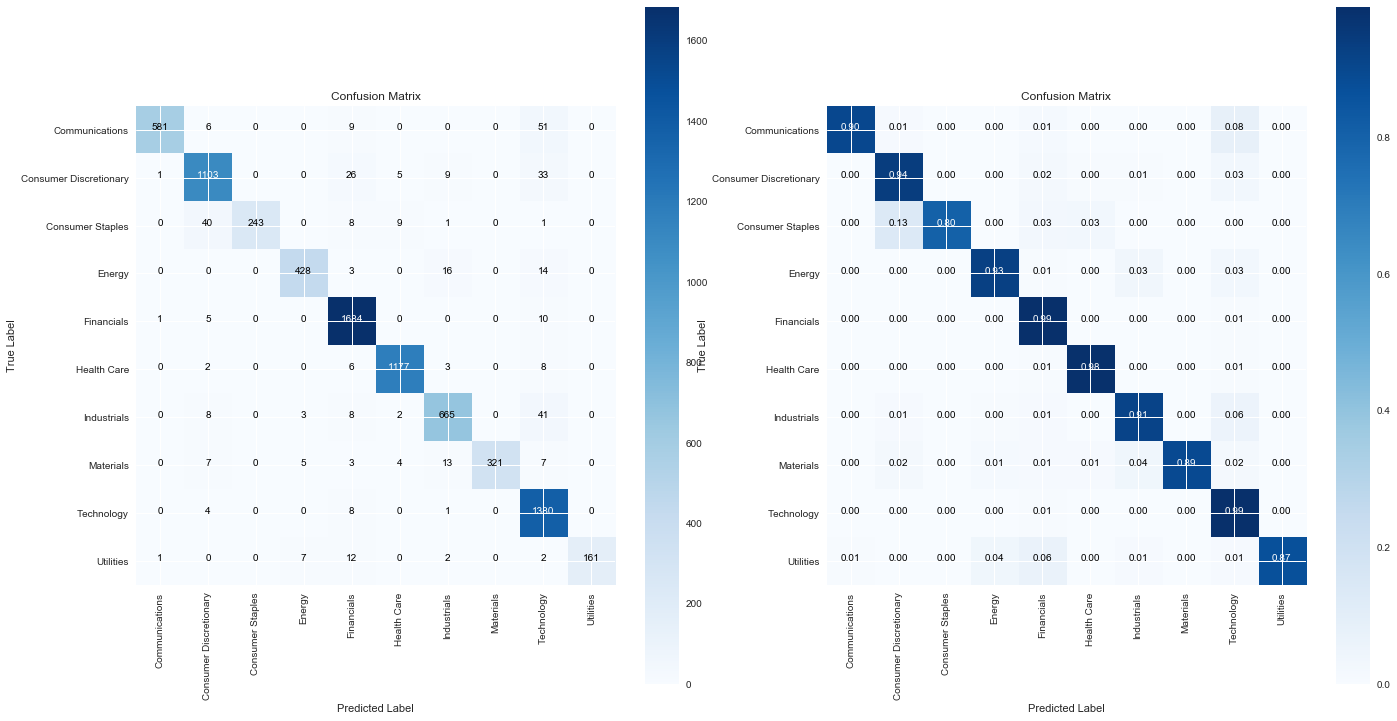

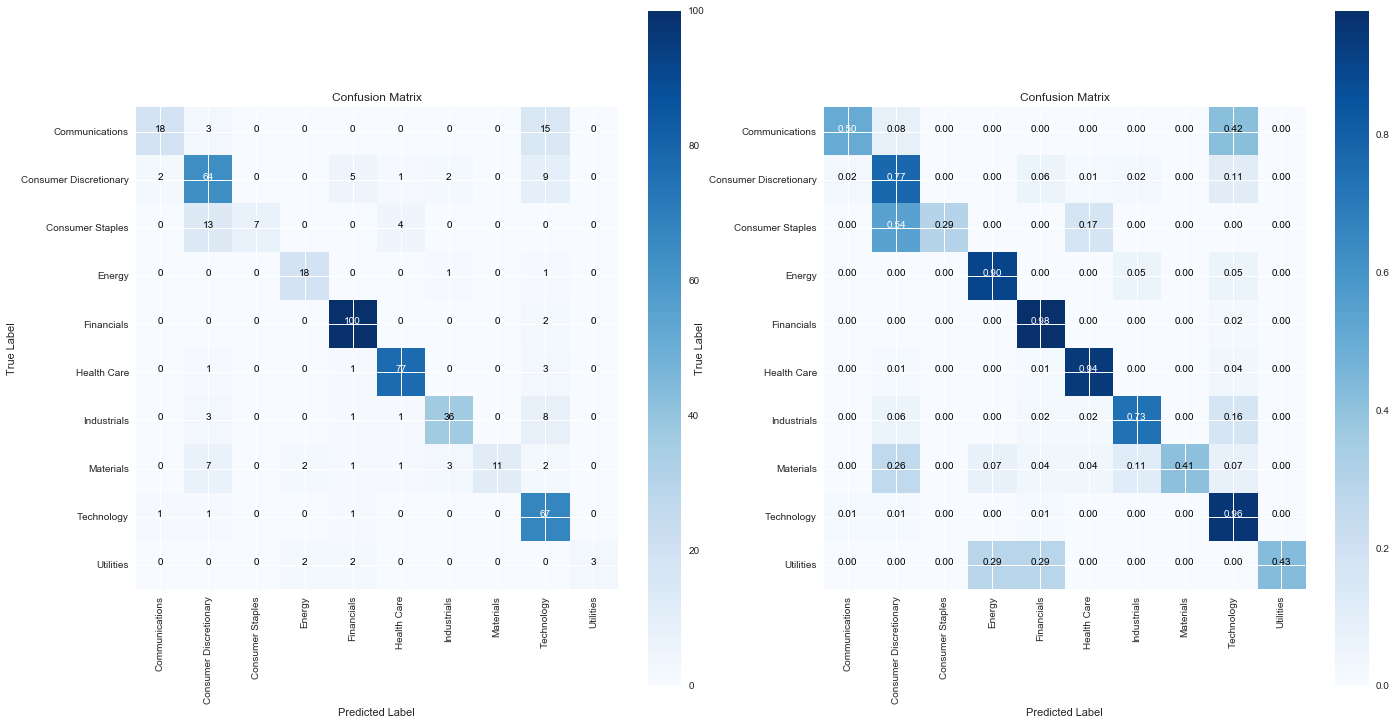

In [194]:
# scikit learn
trainAccuracySkNbBOBW,trainCmSkNbBOBW,trainReportSkNbBOBW,devTestAccuracySkNbBOBW,devTestCmSkNbBOBW,devTestReportSkNbBOBW,classifierSkNbBOBW=evaluateMultinomialNBClassifier(dfTrain,
        dfDevTest,dfTest,wordType='wordsLemmatizedBOBW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkNbBOBW))
print('Accuracy (Development Test): '+str(devTestAccuracySkNbBOBW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkNbBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkNbBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkNbBOBW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkNbBOBW)

Performance of the Multinomial Naive Bayes classifier implementation using the bag of words plus bigram feature set performs better in-sample than the corresponding classifier build using the bag of words feature set. Out-of-sample performance is comparable.

#### Maxent (Logistic Regression) Classifiers

We train and test the NLTK Maxent classifier using a feature set composed of bag of words and bigrams:

Accuracy (Train): 0.972508591065
Accuracy (Development Test): 0.764
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9967    0.9397    0.9674       647
Consumer Discretionary     0.9736    0.9711    0.9724      1177
      Consumer Staples     1.0000    0.8576    0.9234       302
                Energy     0.9888    0.9588    0.9736       461
            Financials     0.9560    0.9976    0.9764      1700
           Health Care     0.9884    0.9967    0.9925      1196
           Industrials     0.9845    0.9629    0.9736       727
             Materials     1.0000    0.9444    0.9714       360
            Technology     0.9436    0.9971    0.9696      1393
             Utilities     1.0000    0.8378    0.9118       185

           avg / total     0.9734    0.9725    0.9722      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communi

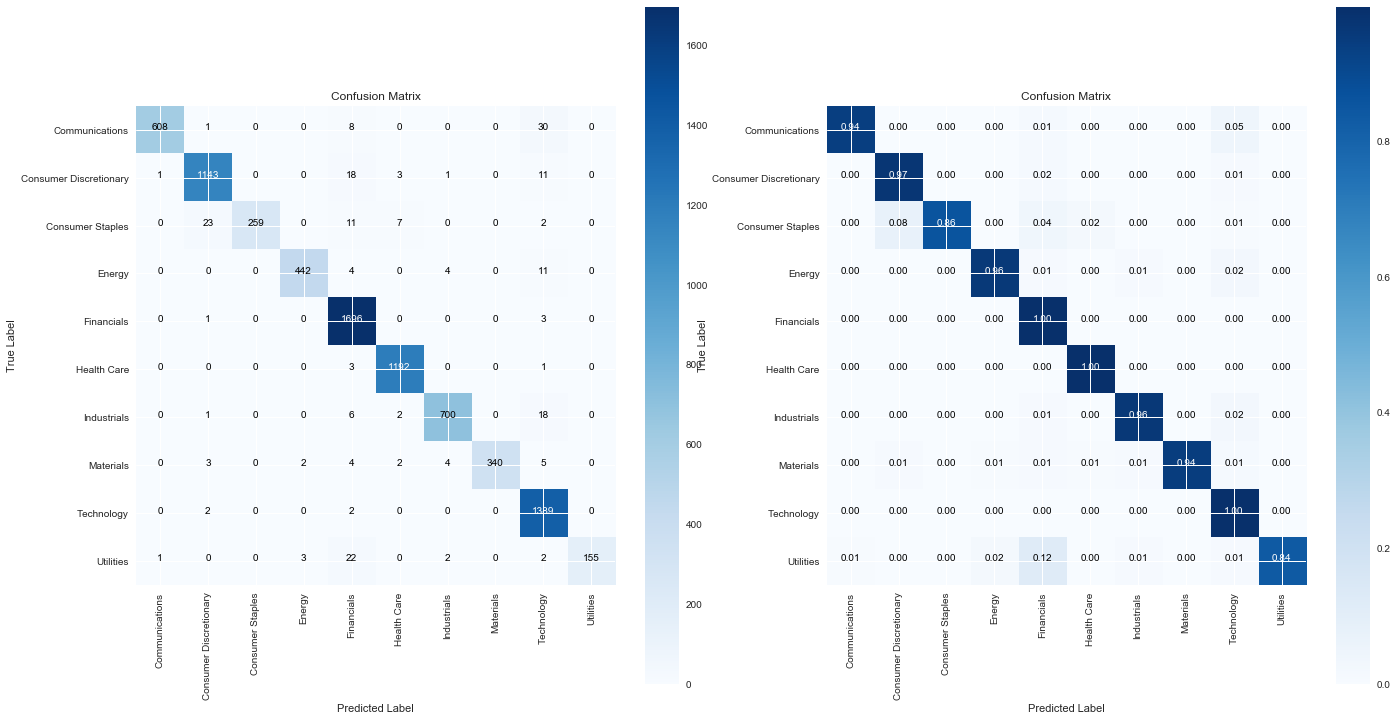

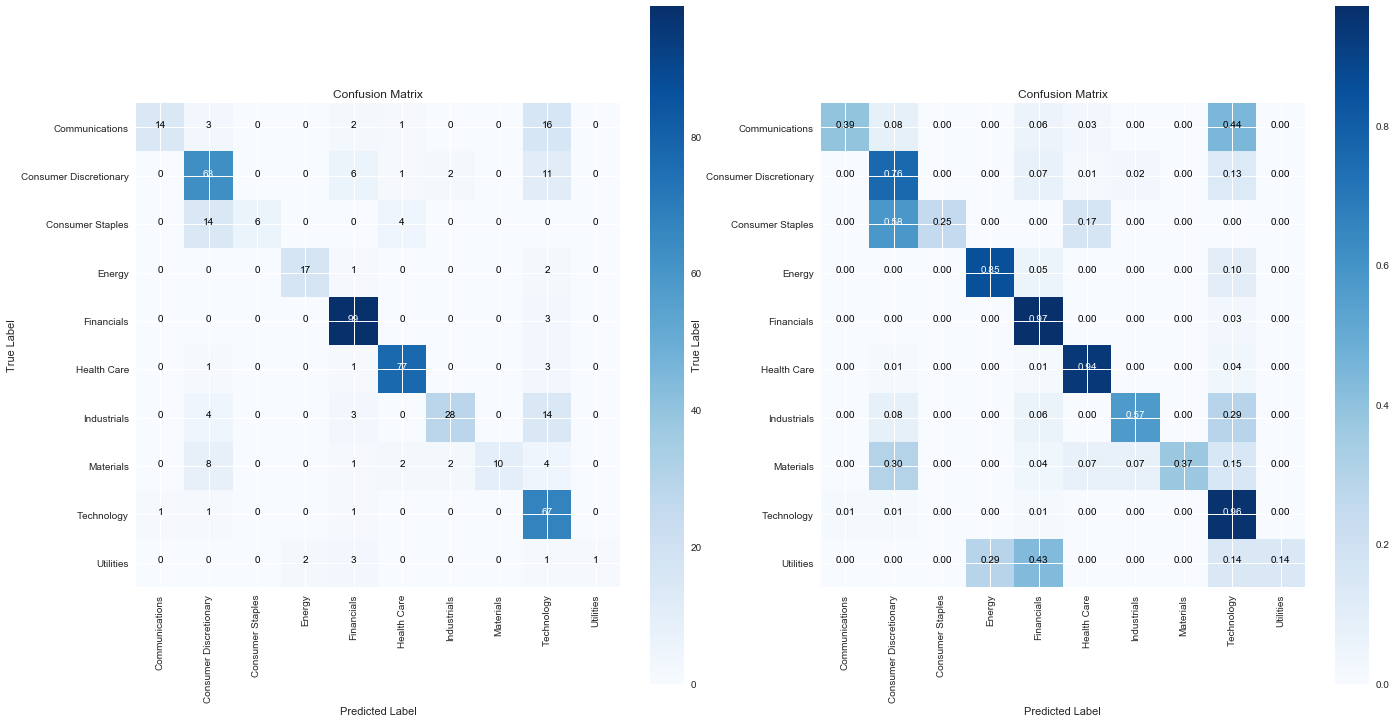

In [186]:
# NLTK
trainAccuracyMeGisBOBW,trainCmMeGisBOBW,trainReportMeGisBOBW,devTestAccuracyMeGisBOBW,devTestCmMeGisBOBW,devTestReportMeGisBOBW,classifierMeGisBOBW=evaluateMaxentClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOBW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracyMeGisBOBW))
print('Accuracy (Development Test): '+str(devTestAccuracyMeGisBOBW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmMeGisBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmMeGisBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportMeGisBOBW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportMeGisBOBW)

Now we test the scikit-learn implementation using our bag of words plus bigram feature sets:

Accuracy (Train): 0.98588610702
Accuracy (Development Test): 0.862
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9858    0.9645    0.9750       647
Consumer Discretionary     0.9863    0.9796    0.9829      1177
      Consumer Staples     1.0000    0.9768    0.9883       302
                Energy     0.9956    0.9913    0.9935       461
            Financials     0.9895    0.9971    0.9933      1700
           Health Care     0.9933    0.9941    0.9937      1196
           Industrials     0.9819    0.9711    0.9765       727
             Materials     1.0000    0.9917    0.9958       360
            Technology     0.9669    0.9849    0.9758      1393
             Utilities     0.9893    1.0000    0.9946       185

           avg / total     0.9860    0.9859    0.9859      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communic

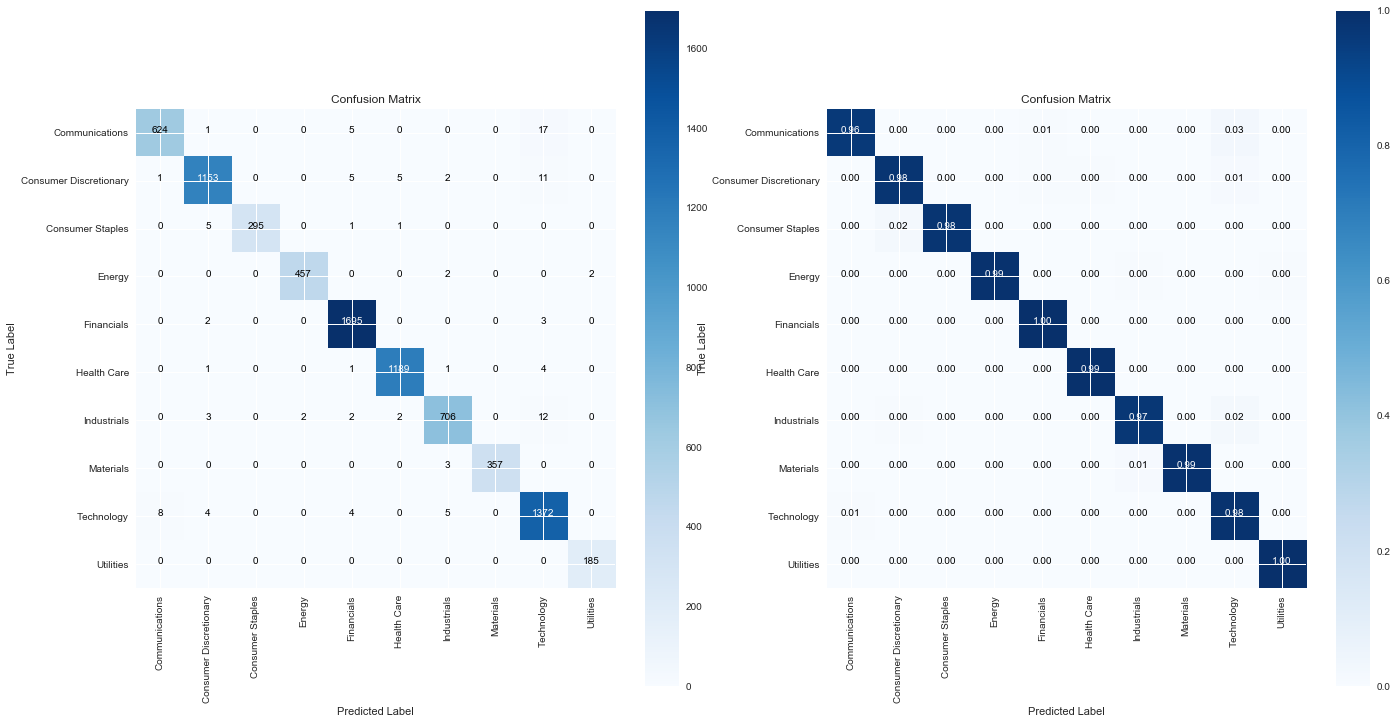

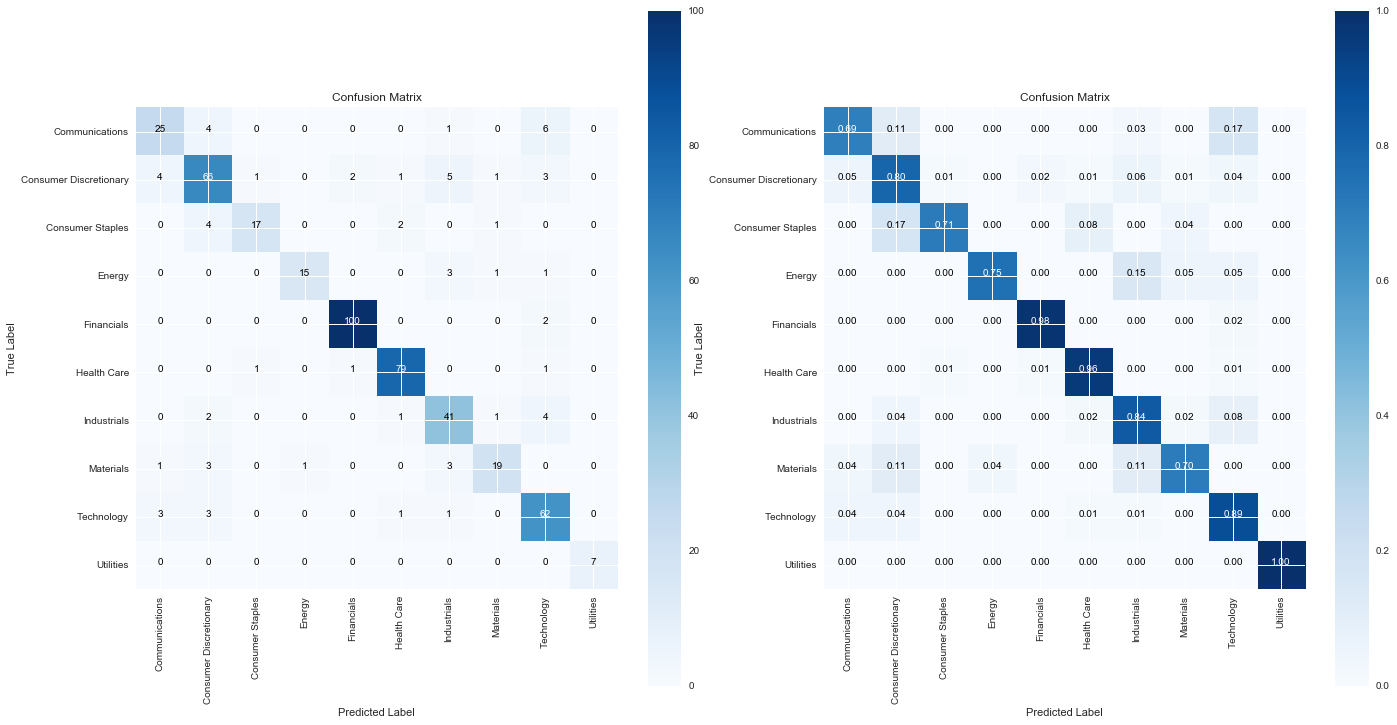

In [195]:
trainAccuracySkLrBOBW,trainCmSkLrBOBW,trainReportSkLrBOBW,devTestAccuracySkLrBOBW,devTestCmSkLrBOBW,devTestReportSkLrBOBW,classifierSkLrBOBW=evaluateLogisticRegressionClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkLrBOBW))
print('Accuracy (Development Test): '+str(devTestAccuracySkLrBOBW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkLrBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkLrBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkLrBOBW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkLrBOBW)

The performance of the scikit-learn logistic regression classifier is once again very impressive, performing in a way similar to that of the corresponding classifier developed using only the bag of words feature set.

#### Linear SVC

We train and test a linear support vector classifier on the bag of words plus bigrams feature set:

Accuracy (Train): 1.0
Accuracy (Development Test): 0.854
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     1.0000    1.0000    1.0000       647
Consumer Discretionary     1.0000    1.0000    1.0000      1177
      Consumer Staples     1.0000    1.0000    1.0000       302
                Energy     1.0000    1.0000    1.0000       461
            Financials     1.0000    1.0000    1.0000      1700
           Health Care     1.0000    1.0000    1.0000      1196
           Industrials     1.0000    1.0000    1.0000       727
             Materials     1.0000    1.0000    1.0000       360
            Technology     1.0000    1.0000    1.0000      1393
             Utilities     1.0000    1.0000    1.0000       185

           avg / total     1.0000    1.0000    1.0000      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-score   support

        Communications    

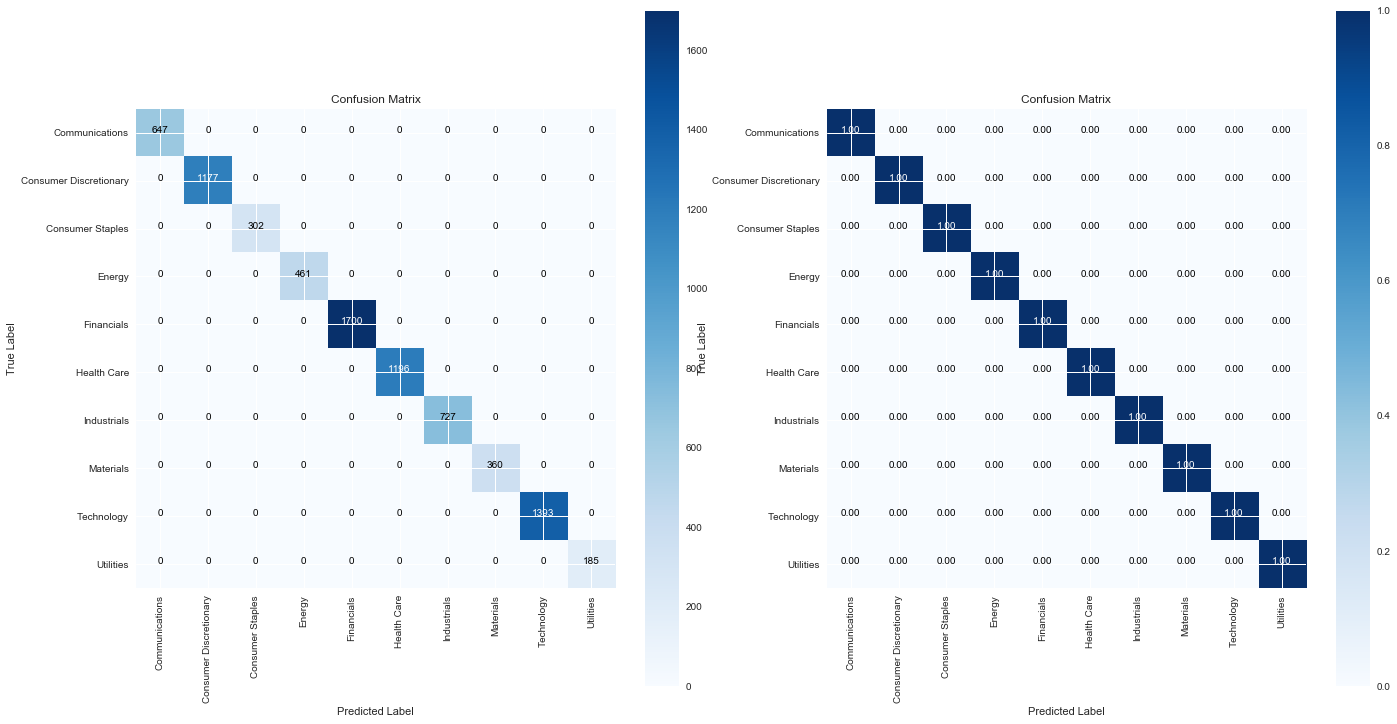

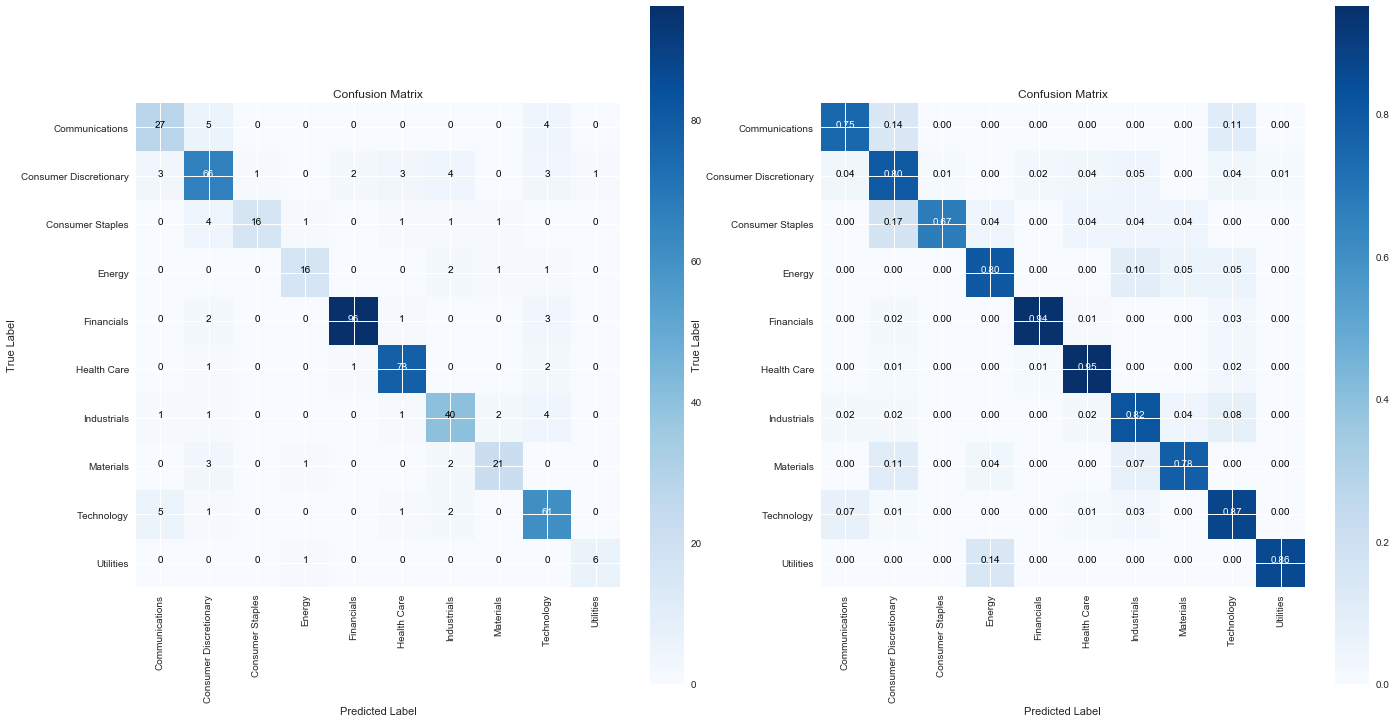

In [189]:
# scikit-learn
trainAccuracySkLsvcBOBW,trainCmSkLsvcBOBW,trainReportSkLsvcBOBW,devTestAccuracySkLsvcBOBW,devTestCmSkLsvcBOBW,devTestReportSkLsvcBOBW,classifierSkLsvcBOBW=evaluateLinearSVCClassifier(dfTrain,
    dfDevTest,dfTest,wordType='wordsLemmatizedBOBW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracySkLsvcBOBW))
print('Accuracy (Development Test): '+str(devTestAccuracySkLsvcBOBW))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCmSkLsvcBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (train)
plot_both_confusion_matrix(devTestCmSkLsvcBOBW,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReportSkLsvcBOBW)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReportSkLsvcBOBW)

We again observe perfect accuracy and f1-scores in training for the linear support vector classifier model. This model appears overfit.

### Final Test

For both feature sets developed - bag of words and bag of words plus bigrams - the scikit-learn implementation of the logistic regression performed best. We select this model as our final classifer and evaluate the model using the final test data set:

Accuracy (Train): 0.98588610702
Accuracy (Development Test): 0.862
Accuracy (Final Test): 0.862
Model Performance Metrics (Train):
                        precision    recall  f1-score   support

        Communications     0.9858    0.9645    0.9750       647
Consumer Discretionary     0.9863    0.9796    0.9829      1177
      Consumer Staples     1.0000    0.9768    0.9883       302
                Energy     0.9956    0.9913    0.9935       461
            Financials     0.9895    0.9971    0.9933      1700
           Health Care     0.9933    0.9941    0.9937      1196
           Industrials     0.9819    0.9711    0.9765       727
             Materials     1.0000    0.9917    0.9958       360
            Technology     0.9669    0.9849    0.9758      1393
             Utilities     0.9893    1.0000    0.9946       185

           avg / total     0.9860    0.9859    0.9859      8148

Model Performance Metrics (Development Test):
                        precision    recall  f1-scor

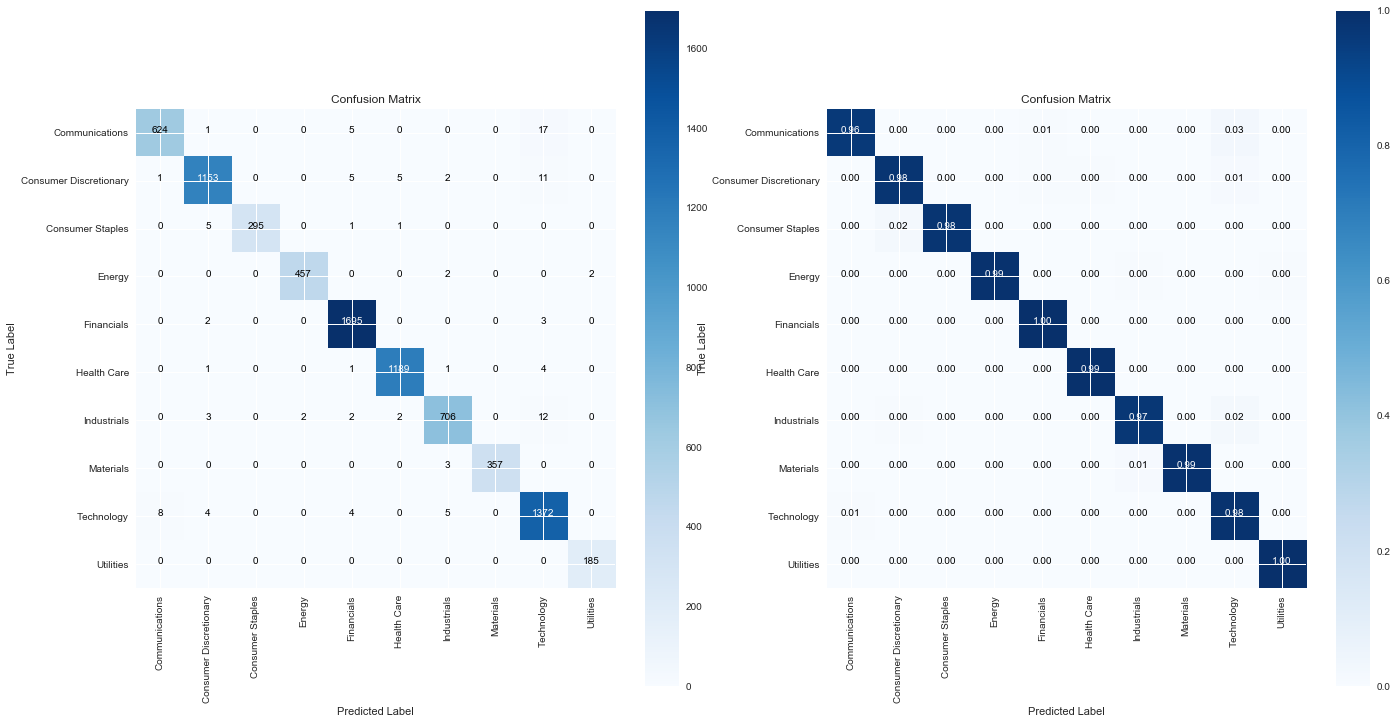

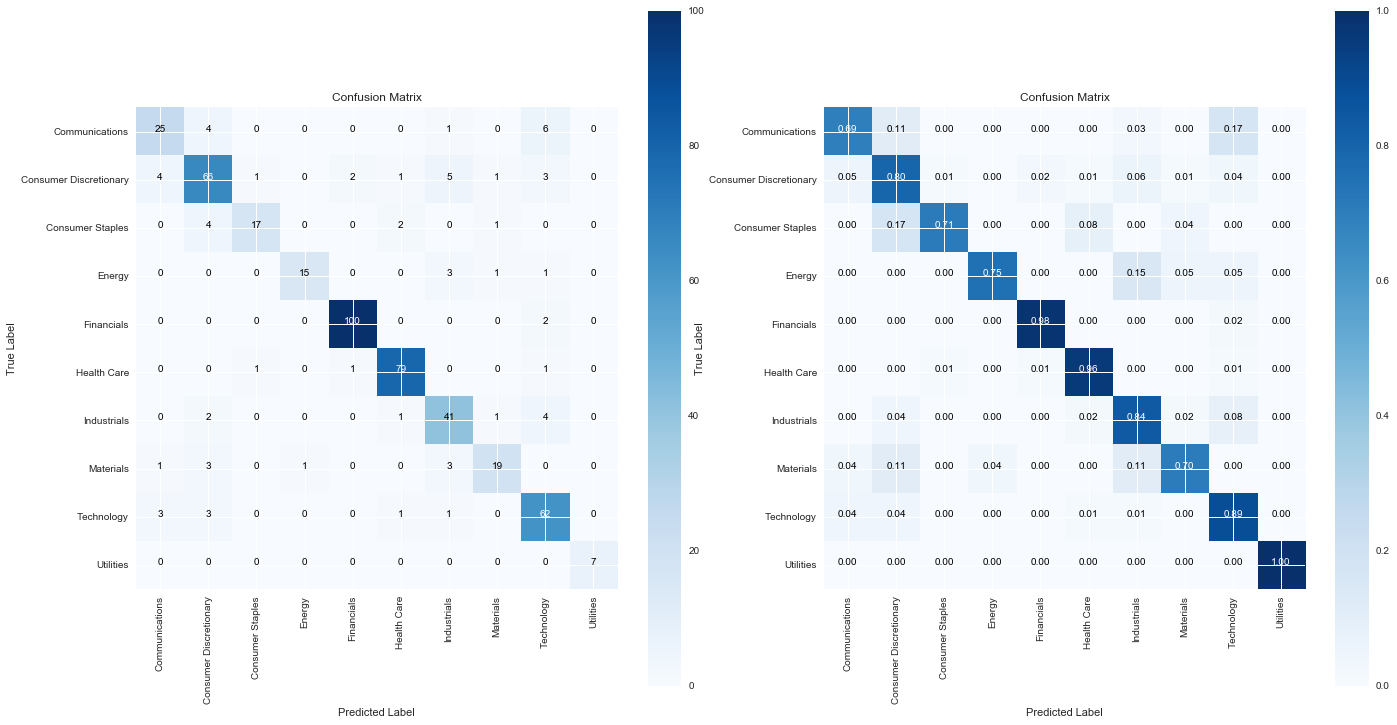

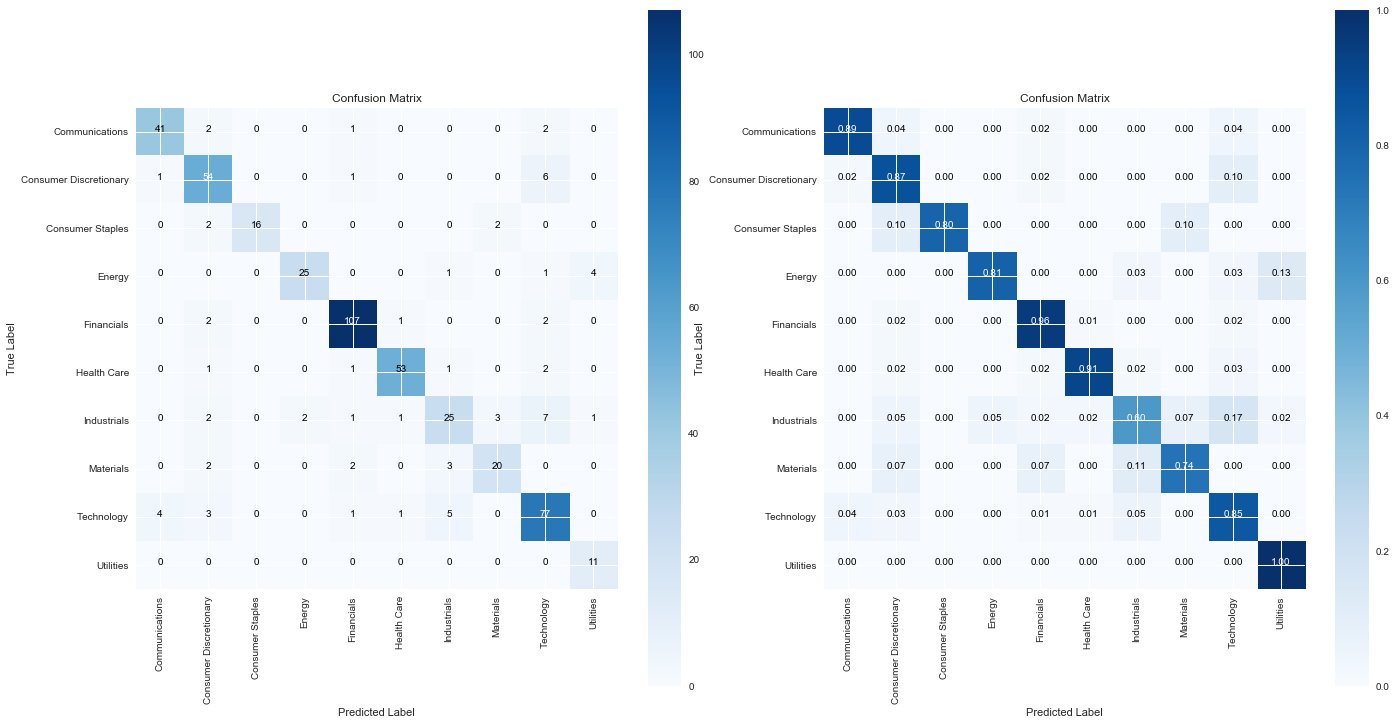

In [200]:
trainAccuracy,trainCm,trainReport,devTestAccuracy,devTestCm,devTestReport,testAccuracy,testCm,testReport,classifier=evaluateFinalLogisticRegressionClassifier(dfTrain,dfDevTest,dfTest,wordType='wordsLemmatizedBOW')
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(trainAccuracy))
print('Accuracy (Development Test): '+str(devTestAccuracy))
print('Accuracy (Final Test): '+str(testAccuracy))
# plot confusion matrix (train)
plot_both_confusion_matrix(trainCm,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (development test)
plot_both_confusion_matrix(devTestCm,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# plot confusion matrix (final test)
plot_both_confusion_matrix(testCm,['Communications','Consumer Discretionary','Consumer Staples',
    'Energy','Financials','Health Care','Industrials','Materials','Technology','Utilities'])
# display performance report (train)
print('Model Performance Metrics (Train):')
print(trainReport)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devTestReport)
# display performance report (final test)
print('Model Performance Metrics (Final Test):')
print(testReport)

Our final model performance is similar in development test and final test evaluations, with the f1-score falling only marginally (0.861 to 0.857). Precision and recall remain relatively well balanced in the final test results. Performance in the 'Industrials' sector is relatively low, with an f1-score close to 'Communications' in the development test results.

We examine the class composition of the training, development testing, and final testing data sets:

In [160]:
# count total number of documents with corresponding  
# sector labels (BICS)
nDocuments=df['bicsSector'].count()
# count number of documents for each BICS sector 
dfBySector=df[['bicsSector','companyDescription']].groupby(['bicsSector']).count()
# column name map
columnNameMap={'companyDescription' : 'totalCount'}
# rename column based on column name map
dfBySector.rename(columns=columnNameMap,inplace=True)
# add frequency (%)
dfBySector['totalPercent']=dfBySector['totalCount']/nDocuments
# count total number of documents with corresponding  
# sector labels (BICS)
nDocumentsTrain=dfTrain['bicsSector'].count()
# count number of documents for each BICS sector 
dfTrainBySector=dfTrain[['bicsSector','companyDescription']].groupby(['bicsSector']).count()
# column name map
columnNameMap={'companyDescription' : 'trainFrequencyCount'}
# rename column based on column name map
dfTrainBySector.rename(columns=columnNameMap,inplace=True)
# add frequency (%)
dfTrainBySector['trainPercent']=dfTrainBySector['trainFrequencyCount']/nDocumentsTrain
# count total number of documents with corresponding  
# sector labels (BICS)
nDocumentsDevTest=dfDevTest['bicsSector'].count()
# count number of documents for each BICS sector 
dfDevTestBySector=dfDevTest[['bicsSector','companyDescription']].groupby(['bicsSector']).count()
# column name map
columnNameMap={'companyDescription' : 'devTestFrequencyCount'}
# rename column based on column name map
dfDevTestBySector.rename(columns=columnNameMap,inplace=True)
# add frequency (%)
dfDevTestBySector['devTestPercent']=dfDevTestBySector['devTestFrequencyCount']/nDocumentsDevTest
# count total number of documents with corresponding  
# sector labels (BICS)
nDocumentsTest=dfTest['bicsSector'].count()
# count number of documents for each BICS sector 
dfTestBySector=dfTest[['bicsSector','companyDescription']].groupby(['bicsSector']).count()
# column name map
columnNameMap={'companyDescription' : 'testFrequencyCount'}
# rename column based on column name map
dfTestBySector.rename(columns=columnNameMap,inplace=True)
# add frequency (%)
dfTestBySector['testPercent']=dfTestBySector['testFrequencyCount']/nDocumentsTest
# concatenate dataframe
dfsBySector=pandas.concat([dfBySector,dfTrainBySector,dfDevTestBySector,
    dfTestBySector], axis=1, join='inner', ignore_index=False)
# define selected columns
columnNames=['trainPercent','devTestPercent','testPercent',
    'totalPercent','totalCount']
# display selected columns
dfsBySector[columnNames]

,trainPercent,devTestPercent,testPercent,totalPercent,totalCount
bicsSector,,,,,
Communications,0.079406,0.072,0.092,0.079690,729
Consumer Discretionary,0.144453,0.166,0.124,0.144512,1322
Consumer Staples,0.037064,0.048,0.040,0.037822,346
Energy,0.056578,0.040,0.062,0.055969,512
Financials,0.208640,0.204,0.224,0.209226,1914
Health Care,0.146784,0.164,0.116,0.146043,1336
Industrials,0.089224,0.098,0.084,0.089418,818
Materials,0.044183,0.054,0.054,0.045256,414
Technology,0.170962,0.140,0.182,0.169873,1554


We can see that the proportion of companies in the 'Communications' class jumps up when we move from training to development test, then back down again when we move from development test to final test. Something similar happens with the proportion of companies in the 'Industrials' sector. This provides some indication as to the cause of the differences in the confusion matrix between training, development testing, and final testing. 

## Conclusion

With a set of very simple features and the logistic regression classifier, we were able to obtain f1-scores in development and final testing above 0.85. The performance of this classifier is likely competitive with human classification given the same information set. Given the importance of sector classifications in the development of characteristic-based factor models, it is likely that this classifier could be used to improve the coverage of such factor models to areas of the equity markets currently not covered by BICS. This classifier can likely be used effectively to infer reasonable sector classifications for companies where BICS sectors are not available. 

Future work should include applications to private companies and should use a balanced sampling approach in the splitting of data into training, development test, and final test sets.

## References

Bengfort , Bilbro , and Ojeda, Applied Text Analysis with Python, O’Reilly 2017

Bird, Klein and Loper, Natural Language Processing with Python, O’Reilly 2009

Jurafsky and Martin, Speech and Language Processing, Prentice Hall 2008

Hardeniya, Perkins,  Chopra, Joshi, and Mathur, Natural Language Processing: Python and NLTK, Packt Publishing 2016

Sarkar, Text Analytics with Python, Apress 2016
